In [1]:
# Nonlinear MPC test using kinematic bicycle model for car
# We want to use the kinematic bicycle model from this paper (Figure 3)
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4

# which has states:
# x, y = positional coordinates in inertial frame
# ψ = angle of car centerline in inertial frame
# ̇ψ = change of angle
# β = angle between car centerline and velocity vector
# ̇β = change of angle

# and has the equations:
# ̇x = v cos(ψ + β)
# ̇y = v sin(ψ + β)
# ̇v = a
# ̇ψ = v / lᵣ sin(β)
# β = arctan(lᵣ/(lf + lᵣ) tan(δf))
# ̇β = v/(lf + lᵣ) tan(δf) - v/lᵣ sin(β)
# ̇δf = ω

# and we want to solve it. Define the model:


The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\\ \beta\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}
where the two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).
The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}
\end{gather*}

## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [2]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl

# Local dependencies
from direct_collocation  import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar
from roadrunner          import Roadrunner, RoadSegment
from road                import test_road, iso_double_lane_change

## Initial state and cost

In [3]:
# Initialize the car model with 0.05 second steps and 30 step lookahead
car = KinematicBicycleCar(N=30, step=0.05)

# Cost - we want the velocity to stay around 5 m/s, so we penalize deviations from that.
cost = (car.dae.x[0][2]-5)**2

In [4]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road,                    # Road centerline points
                        road_width  = np.ones(n_test_road_pts)*5.0, # constant lane width of 5 meters
                        P           = 20) # Number of points to try curve-fitting at a time

# Initial conditions: x,y = 0,0, velocity = 5.5 m/s, car at 22.5-degree angle
# This is the model:
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1/figures/3
ic = [test_road[0,0], test_road[0,1], 5.5, roadrunner.get_angle()]
car.set_initial(ic)

In [5]:
# Boundary functions

# terrible hack, need to fix right away
global prev_k
prev_k= 0
dist_already_traveled = 0.0

def road_center(model:KinematicBicycleCar, k:int):
    global prev_k
    if k == prev_k+1:
        roadrunner.advance(model.step*model.state_estimate[2,k])
        prev_k = k
    if k == 0:
        roadrunner.reset()
        roadrunner.advance(dist_already_traveled)
        prev_k = k
    center = np.empty((3,))
    center[0:2] = np.reshape(roadrunner.evaluate(),2)
    center[2]   = roadrunner.get_angle()
    return center

def upperbounds_x(model:KinematicBicycleCar, k:int):
    xy = road_center(model, k)
    bound = model.upperbounds_x(k)
    
    # Add the road width
    angle = roadrunner.get_angle()
    width = roadrunner.get_width()
    
    xy_0 = (width/2*np.cos(np.pi/2 + angle) + 5*np.cos(angle))
    bound[0] = xy[0] + xy_0*np.sign(xy_0)
    xy_1 = (width/2*np.sin(np.pi/2 + angle) + 5*np.sin(angle))
    bound[1] = xy[1] + xy_1*np.sign(xy_1)
    
    return bound

def lowerbounds_x(model:KinematicBicycleCar, k:int):
    xy = road_center(model, k)
    bound = model.lowerbounds_x(k)
    
    # Add the road width
    angle = roadrunner.get_angle()
    width = roadrunner.get_width()
    
    xy_0 = (width/2*np.cos(np.pi/2 + angle) + 5*np.cos(angle))
    bound[0] = xy[0] - xy_0*np.sign(xy_0)
    xy_1 = (width/2*np.sin(np.pi/2 + angle) + 5*np.sin(angle))
    bound[1] = xy[1] - xy_1*np.sign(xy_1)
    
    return bound

def upperbounds_u(model:KinematicBicycleCar, k:int):
    bound = model.upperbounds_u(k)
    return bound

def lowerbounds_u(model:KinematicBicycleCar, k:int):
    bound = model.lowerbounds_u(k)
    return bound

In [6]:
# What we should do now
# 1. Use the velocity estimate to "step through" the road,
#    obtaining a set of road midpoints and constraint boundaries
# 2. Add a term to the cost function that attracts the successive states to the road midpoints - done
# 3. Use the midpoints to initialize the variable estimate so the solver is faster. - done,
#    and we are initializing the new control uk to the previously computed one
#    kind of warm-starting ipopt

#from collections import deque

#v_estimate = np.ones(car.N)*ic[2]
#road_points = deque(maxlen=car.N)
#dist = 0.0
#roadrunner.reset()

#for v in v_estimate:
#    roadrunner.advance(v*car.step)
#    xy = roadrunner.evaluate()
#    road_points.append(np.reshape(xy,2))


## Run the MPC algorithm

In [7]:
roadrunner.reset()
prev_k = 0

mpcprob = MpcProblem(car,     # casadi.DaeBuilder()
                     cost,        # casadi symbolic objective
                     upperbounds_x=upperbounds_x,
                     lowerbounds_x=lowerbounds_x,
                     upperbounds_u=upperbounds_u,
                     lowerbounds_u=lowerbounds_u,
                     road_center=road_center,
                    )

# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 250

x_plan = np.empty((mpcprob.model.n,n_runs+1))
u_plan = np.empty((mpcprob.model.m,n_runs))
x_true = np.empty((mpcprob.model.n,n_runs+1))
x_true[:,0] = ic
x_plan[:,0] = ic

boundary_up  = np.empty((n_runs,2))
boundary_low = np.empty((n_runs,2))


for k in range(n_runs):
    xk_opt, uk_opt = mpcprob.run(x_true[:,k])
    for i in range(mpcprob.model.n):
        x_plan[i,k+1] = xk_opt[i][1]
    for i in range(mpcprob.model.m):
        u_plan[i,k] = uk_opt[i][1]
    x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])
    
    dist_already_traveled += np.sqrt((x_true[0,k+1]-x_true[0,k])**2 + (x_true[1,k+1]-x_true[1,k])**2)

    boundary_up[k,:] = upperbounds_x(mpcprob.model, 0)[0:2]
    boundary_low[k,:] = lowerbounds_x(mpcprob.model, 0)[0:2]
        
    
    # hack to demonstrate changing the cost halfway through the number of runs
    #if k = n_runs//2:
        # now the cost is penalizing velocity, so the car will stop.
    #    mpcprob.set_cost(100*car.dae.x[0][2]**2)

# This was to compare the error between the prediction and
# the simulation using casadi ODE integrator
# the error is very small.
#for k in range(1,n_runs):
    #print("True:", x_true[:,k])
    #print("Pred:", x_plan[:,k])
    #print("Error:", np.linalg.norm(x_true[:,k]-x_plan[:,k],2))

# Get the planned boundaries
boundary_plan_up = np.empty((mpcprob.model.N,2))
boundary_plan_low = np.empty((mpcprob.model.N,2))
for k in range(mpcprob.model.N):
    boundary_plan_up[k,:] = upperbounds_x(mpcprob.model, k)[0:2]
    boundary_plan_low[k,:] = lowerbounds_x(mpcprob.model, k)[0:2]
    
# Add them to the boundaries for past states
boundary_up = np.concatenate([boundary_up, boundary_plan_up])
boundary_low = np.concatenate([boundary_low, boundary_plan_low])

Attracting  X_1[0] 1 to  [0.71297965 0.81051745 0.06659183]
Attracting  X_2[0] 2 to  [0.94236138 0.82653164 0.06659183]
Attracting  X_3[0] 3 to  [1.17209337 0.84300371 0.06659183]
Attracting  X_4[0] 4 to  [1.40213326 0.85989543 0.06659183]
Attracting  X_5[0] 5 to  [1.63244706 0.87716938 0.06659183]
Attracting  X_6[0] 6 to  [1.86300828 0.89478917 0.06659183]
Attracting  X_7[0] 7 to  [2.09379698 0.91271948 0.06659183]
Attracting  X_8[0] 8 to  [2.32479904 0.93092622 0.06659183]
Attracting  X_9[0] 9 to  [2.55600534 0.94937654 0.06659183]
Attracting  X_10[0] 10 to  [2.78741115 0.96803888 0.06659183]
Attracting  X_11[0] 11 to  [3.01901547 0.986883   0.06659183]
Attracting  X_12[0] 12 to  [3.37025077 0.98748987 0.06659183]
Attracting  X_13[0] 13 to  [3.60138357 1.00295006 0.06659183]
Attracting  X_14[0] 14 to  [3.83216573 1.01839882 0.06659183]
Attracting  X_15[0] 15 to  [4.06268398 1.03379973 0.06659183]
Attracting  X_16[0] 16 to  [4.29301861 1.04912107 0.06659183]
Attracting  X_17[0] 17 to 

  71  2.8329152e+00 4.97e-07 8.81e+00  -1.0 3.17e-03   3.4 1.00e+00 1.00e+00f  1
  72  2.8328129e+00 1.86e-06 4.68e+00  -1.0 5.07e-03   3.0 1.00e+00 1.00e+00f  1
  73  2.8324712e+00 4.55e-06 2.90e+00  -1.0 9.50e-03   2.5 1.00e+00 1.00e+00f  1
  74  2.8315032e+00 1.50e-05 1.53e+00  -1.0 1.53e-02   2.0 1.00e+00 1.00e+00f  1
  75  2.8285310e+00 3.82e-05 8.78e-01  -1.0 2.70e-02   1.5 1.00e+00 1.00e+00f  1
  76  2.8220960e+00 4.42e-06 9.39e-02  -1.7 8.15e-03   1.1 1.00e+00 1.00e+00f  1
  77  2.8025914e+00 2.58e-06 4.56e-02  -2.5 1.19e-02   0.6 1.00e+00 1.00e+00f  1
  78  2.7424472e+00 2.82e-05 5.06e-02  -2.5 3.96e-02   0.1 1.00e+00 1.00e+00f  1
  79  2.5863026e+00 2.54e-04 3.60e-02  -2.5 8.44e-02  -0.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.2497739e+00 1.87e-03 4.13e-02  -2.5 2.80e-01  -0.8 1.00e+00 7.78e-01f  1
  81  1.5697520e+00 1.01e-02 4.07e-02  -2.5 6.36e-01  -1.3 5.97e-01 8.37e-01f  1
  82  5.5444978e-01 2.80e-02

Attracting  X_18[0] 18 to  [4.8214356  1.08384593 0.06659183]
Attracting  X_19[0] 19 to  [5.03072454 1.09738185 0.06659183]
Attracting  X_20[0] 20 to  [5.2400866  1.11077367 0.06659183]
Attracting  X_21[0] 21 to  [5.44956001 1.12400939 0.06659183]
Attracting  X_22[0] 22 to  [5.65917975 1.13707826 0.06659183]
Attracting  X_23[0] 23 to  [5.86897775 1.14997052 0.06659183]
Attracting  X_24[0] 24 to  [6.15088612 1.17610576 0.1203909 ]
Attracting  X_25[0] 25 to  [6.35215563 1.20012671 0.1203909 ]
Attracting  X_26[0] 26 to  [6.55414156 1.22383577 0.1203909 ]
Attracting  X_27[0] 27 to  [6.75683811 1.24724783 0.1203909 ]
Attracting  X_28[0] 28 to  [6.96023703 1.27037554 0.1203909 ]
Attracting  X_29[0] 29 to  [7.16432823 1.29322943 0.1203909 ]
Attracting  X_30[0] 30 to  [7.36910036 1.31581803 0.1203909 ]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian.

Attracting  X_12[0] 12 to  [4.00507316 1.0299557  0.06659183]
Attracting  X_13[0] 13 to  [4.21450984 1.04390852 0.06659183]
Attracting  X_14[0] 14 to  [4.42383571 1.05778013 0.06659183]
Attracting  X_15[0] 15 to  [4.63310359 1.07155146 0.06659183]
Attracting  X_16[0] 16 to  [4.84236226 1.08520563 0.06659183]
Attracting  X_17[0] 17 to  [5.0516567  1.09872772 0.06659183]
Attracting  X_18[0] 18 to  [5.26102823 1.11210444 0.06659183]
Attracting  X_19[0] 19 to  [5.47051475 1.12532395 0.06659183]
Attracting  X_20[0] 20 to  [5.68015093 1.13837558 0.06659183]
Attracting  X_21[0] 21 to  [5.8899684  1.15124968 0.06659183]
Attracting  X_22[0] 22 to  [6.17098063 1.17852235 0.1203909 ]
Attracting  X_23[0] 23 to  [6.37232196 1.20251138 0.1203909 ]
Attracting  X_24[0] 24 to  [6.57437926 1.2261901  0.1203909 ]
Attracting  X_25[0] 25 to  [6.77714645 1.24957319 0.1203909 ]
Attracting  X_26[0] 26 to  [6.98061507 1.27267309 0.1203909 ]
Attracting  X_27[0] 27 to  [7.18477491 1.2955001  0.1203909 ]
Attracti

Attracting  X_2[0] 2 to  [2.22502108 0.92303232 0.06659183]
Attracting  X_3[0] 3 to  [2.43512082 0.93970351 0.06659183]
Attracting  X_4[0] 4 to  [2.64538702 0.95656341 0.06659183]
Attracting  X_5[0] 5 to  [2.8558174  0.97358873 0.06659183]
Attracting  X_6[0] 6 to  [3.06641209 0.9907571  0.06659183]
Attracting  X_7[0] 7 to  [3.39653483 0.98924591 0.06659183]
Attracting  X_8[0] 8 to  [3.60663058 1.00330134 0.06659183]
Attracting  X_9[0] 9 to  [3.81643832 1.01734653 0.06659183]
Attracting  X_10[0] 10 to  [4.02602332 1.03135404 0.06659183]
Attracting  X_11[0] 11 to  [4.23544643 1.04529967 0.06659183]
Attracting  X_12[0] 12 to  [4.4447642  1.05916207 0.06659183]
Attracting  X_13[0] 13 to  [4.65402902 1.0729224  0.06659183]
Attracting  X_14[0] 14 to  [4.86328931 1.08656401 0.06659183]
Attracting  X_15[0] 15 to  [5.07258965 1.10007213 0.06659183]
Attracting  X_16[0] 16 to  [5.28197103 1.11343365 0.06659183]
Attracting  X_17[0] 17 to  [5.49147101 1.12663683 0.06659183]
Attracting  X_18[0] 18 t

  10  1.0416616e-03 2.00e-12 6.83e-14  -8.6 7.78e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0416615613631401e-03    1.0416615613631401e-03
Dual infeasibility......:   6.8322975427747652e-14    6.8322975427747652e-14
Constraint violation....:   1.9988056348951844e-12    1.9988056348951844e-12
Complementarity.........:   2.5478533671454629e-09    2.5478533671454629e-09
Overall NLP error.......:   2.5478533671454629e-09    2.5478533671454629e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w

   9  1.0417710e-03 4.21e-11 2.13e-08  -8.6 3.52e-02    -  9.94e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0416616e-03 1.93e-14 5.25e-08  -8.6 5.25e-04  -4.0 1.00e+00 1.00e+00h  1
  11  1.0416615e-03 5.06e-07 1.73e-09  -8.6 4.18e-03    -  1.00e+00 1.00e+00h  1
  12  1.0416615e-03 3.38e-14 2.85e-11  -8.6 8.54e-07  -4.5 1.00e+00 1.00e+00h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   1.0416615345015571e-03    1.0416615345015571e-03
Dual infeasibility......:   2.8482079636733346e-11    2.8482079636733346e-11
Constraint violation....:   3.3806291099836017e-14    3.3806291099836017e-14
Complementarity.........:   2.5059035597570061e-09    2.5059035597570061e-09
Overall NLP error.......:   2.5059035597570061e-09    2.5059035597570061e-09


Number of objective function evaluations             = 13
Number of objective gradient evaluations        

Attracting  X_1[0] 1 to  [3.45959759 0.99346182 0.06659183]
Attracting  X_2[0] 2 to  [3.6695998  1.00751727 0.06659183]
Attracting  X_3[0] 3 to  [3.87933408 1.02155388 0.06659183]
Attracting  X_4[0] 4 to  [4.08886432 1.03554523 0.06659183]
Attracting  X_5[0] 5 to  [4.29825008 1.04946801 0.06659183]
Attracting  X_6[0] 6 to  [4.50754664 1.06330166 0.06659183]
Attracting  X_7[0] 7 to  [4.7168052  1.07702804 0.06659183]
Attracting  X_8[0] 8 to  [4.92607299 1.09063107 0.06659183]
Attracting  X_9[0] 9 to  [5.1353935  1.10409652 0.06659183]
Attracting  X_10[0] 10 to  [5.34480667 1.11741171 0.06659183]
Attracting  X_11[0] 11 to  [5.55434907 1.13056528 0.06659183]
Attracting  X_12[0] 12 to  [5.76405412 1.14354701 0.06659183]
Attracting  X_13[0] 13 to  [5.97395232 1.15634759 0.06659183]
Attracting  X_14[0] 14 to  [6.25143063 1.18815619 0.1203909 ]
Attracting  X_15[0] 15 to  [6.4530589  1.21201919 0.1203909 ]
Attracting  X_16[0] 16 to  [6.65540102 1.23557803 0.1203909 ]
Attracting  X_17[0] 17 to 

Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.016
Total CPU secs in NLP function evaluations           =      0.017

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 937.00us ( 85.18us) 952.40us ( 86.58us)        11
       nlp_g  |   1.46ms (133.09us)   1.46ms (133.17us)        11
  nlp_grad_f  |   2.89ms (240.92us)   2.86ms (238.30us)        12
  nlp_hess_l  |   7.43ms (742.60us)   7.43ms (742.72us)        10
   nlp_jac_g  |   7.50ms (625.08us)   7.51ms (625.66us)        12
       total  |  38.43ms ( 38.43ms)  37.96ms ( 37.96ms)         1
Attracting  X_1[0] 1 to  [3.90029518 1.02295545 0.06659183]
Attracting  X_2[0] 2 to  [4.10980837 1.03694095 0.06659183]
Attracting  X_3[0] 3 to  

Attracting  X_1[0] 1 to  [4.34011469 1.05224248 0.06659183]
Attracting  X_2[0] 2 to  [4.54939969 1.06605605 0.06659183]
Attracting  X_3[0] 3 to  [4.75865643 1.07975898 0.06659183]
Attracting  X_4[0] 4 to  [4.9679314  1.09333558 0.06659183]
Attracting  X_5[0] 5 to  [5.17726736 1.10677195 0.06659183]
Attracting  X_6[0] 6 to  [5.38670355 1.12005569 0.06659183]
Attracting  X_7[0] 7 to  [5.59627591 1.13317568 0.06659183]
Attracting  X_8[0] 8 to  [5.80601725 1.14612189 0.06659183]
Attracting  X_9[0] 9 to  [6.01595749 1.15888519 0.06659183]
Attracting  X_10[0] 10 to  [6.29169878 1.19295385 0.1203909 ]
Attracting  X_11[0] 11 to  [6.49347027 1.2167548  0.1203909 ]
Attracting  X_12[0] 12 to  [6.69595439 1.24025453 0.1203909 ]
Attracting  X_13[0] 13 to  [6.89914358 1.26346635 0.1203909 ]
Attracting  X_14[0] 14 to  [7.10302825 1.28640141 0.1203909 ]
Attracting  X_15[0] 15 to  [7.30759737 1.30906881 0.1203909 ]
Attracting  X_16[0] 16 to  [7.51283888 1.33147577 0.1203909 ]
Attracting  X_17[0] 17 to 

Attracting  X_3[0] 3 to  [5.19820542 1.10810736 0.06659183]
Attracting  X_4[0] 4 to  [5.40765369 1.1213752  0.06659183]
Attracting  X_5[0] 5 to  [5.6172415  1.13447825 0.06659183]
Attracting  X_6[0] 6 to  [5.82700143 1.14740657 0.06659183]
Attracting  X_7[0] 7 to  [6.1107175  1.17126254 0.1203909 ]
Attracting  X_8[0] 8 to  [6.3118433  1.19534788 0.1203909 ]
Attracting  X_9[0] 9 to  [6.51368632 1.21911804 0.1203909 ]
Attracting  X_10[0] 10 to  [6.71624132 1.24258842 0.1203909 ]
Attracting  X_11[0] 11 to  [6.91950052 1.2657721  0.1203909 ]
Attracting  X_12[0] 12 to  [7.12345415 1.28868001 0.1203909 ]
Attracting  X_13[0] 13 to  [7.32809106 1.31132108 0.1203909 ]
Attracting  X_14[0] 14 to  [7.53339912 1.33370232 0.1203909 ]
Attracting  X_15[0] 15 to  [7.73936565 1.355829   0.1203909 ]
Attracting  X_16[0] 16 to  [7.94597772 1.37770473 0.1203909 ]
Attracting  X_17[0] 17 to  [8.15322243 1.39933162 0.1203909 ]
Attracting  X_18[0] 18 to  [8.36108717 1.42071035 0.1203909 ]
Attracting  X_19[0] 19

Attracting  X_1[0] 1 to  [5.2191449  1.10944125 0.06659183]
Attracting  X_2[0] 2 to  [5.42860556 1.12269309 0.06659183]
Attracting  X_3[0] 3 to  [5.63820918 1.1357791  0.06659183]
Attracting  X_4[0] 4 to  [5.84798799 1.14868943 0.06659183]
Attracting  X_5[0] 5 to  [6.13079766 1.17368573 0.1203909 ]
Attracting  X_6[0] 6 to  [6.33199533 1.1977388  0.1203909 ]
Attracting  X_7[0] 7 to  [6.53390983 1.22147833 0.1203909 ]
Attracting  X_8[0] 8 to  [6.73653564 1.24491949 0.1203909 ]
Attracting  X_9[0] 9 to  [6.93986474 1.26807513 0.1203909 ]
Attracting  X_10[0] 10 to  [7.14388722 1.29095599 0.1203909 ]
Attracting  X_11[0] 11 to  [7.34859181 1.31357079 0.1203909 ]
Attracting  X_12[0] 12 to  [7.55396629 1.33592637 0.1203909 ]
Attracting  X_13[0] 13 to  [7.75999796 1.35802781 0.1203909 ]
Attracting  X_14[0] 14 to  [7.96667387 1.37987859 0.1203909 ]
Attracting  X_15[0] 15 to  [8.17398115 1.40148065 0.1203909 ]
Attracting  X_16[0] 16 to  [8.38190721 1.42283456 0.1203909 ]
Attracting  X_17[0] 17 to 


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0415949312747406e-03    1.0415949312747406e-03
Dual infeasibility......:   1.3747600842466847e-11    1.3747600842466847e-11
Constraint violation....:   2.3664514792187674e-11    2.3664514792187674e-11
Complementarity.........:   2.5572297753626399e-09    2.5572297753626399e-09
Overall NLP error.......:   2.5572297753626399e-09    2.5572297753626399e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.019
Total CPU secs in NLP function evaluation

Attracting  X_1[0] 1 to  [6.17097925 1.17852218 0.1203909 ]
Attracting  X_2[0] 2 to  [6.37232057 1.20251121 0.1203909 ]
Attracting  X_3[0] 3 to  [6.57437786 1.22618994 0.1203909 ]
Attracting  X_4[0] 4 to  [6.77714504 1.24957303 0.1203909 ]
Attracting  X_5[0] 5 to  [6.98061366 1.27267293 0.1203909 ]
Attracting  X_6[0] 6 to  [7.1847735  1.29549994 0.1203909 ]
Attracting  X_7[0] 7 to  [7.38961306 1.3180624  0.1203909 ]
Attracting  X_8[0] 8 to  [7.59512001 1.3403668  0.1203909 ]
Attracting  X_9[0] 9 to  [7.80128156 1.36241789 0.1203909 ]
Attracting  X_10[0] 10 to  [8.00808476 1.38421882 0.1203909 ]
Attracting  X_11[0] 11 to  [8.21551679 1.40577124 0.1203909 ]
Attracting  X_12[0] 12 to  [8.42356514 1.42707547 0.1203909 ]
Attracting  X_13[0] 13 to  [8.63221778 1.44813054 0.1203909 ]
Attracting  X_14[0] 14 to  [9.07547607 1.52827363 0.06991598]
Attracting  X_15[0] 15 to  [9.2878309  1.54310243 0.06991598]
Attracting  X_16[0] 16 to  [9.50083724 1.55789508 0.06991598]
Attracting  X_17[0] 17 to 

Attracting  X_2[0] 2 to  [6.79746024 1.25189555 0.1203909 ]
Attracting  X_3[0] 3 to  [7.00099847 1.27496773 0.1203909 ]
Attracting  X_4[0] 4 to  [7.20522681 1.29776794 0.1203909 ]
Attracting  X_5[0] 5 to  [7.41013368 1.32030434 0.1203909 ]
Attracting  X_6[0] 6 to  [7.61570666 1.34258322 0.1203909 ]
Attracting  X_7[0] 7 to  [7.82193296 1.36460917 0.1203909 ]
Attracting  X_8[0] 8 to  [8.02879962 1.3863852  0.1203909 ]
Attracting  X_9[0] 9 to  [8.23629384 1.40791282 0.1203909 ]
Attracting  X_10[0] 10 to  [8.44440314 1.42919219 0.1203909 ]
Attracting  X_11[0] 11 to  [8.65311558 1.45022224 0.1203909 ]
Attracting  X_12[0] 12 to  [9.09668028 1.52975737 0.06991598]
Attracting  X_13[0] 13 to  [9.30910289 1.54458374 0.06991598]
Attracting  X_14[0] 14 to  [9.52217134 1.55937133 0.06991598]
Attracting  X_15[0] 15 to  [9.73583412 1.57409405 0.06991598]
Attracting  X_16[0] 16 to  [9.95004845 1.58872601 0.06991598]
Attracting  X_17[0] 17 to  [10.16477935  1.60324167  0.06991598]
Attracting  X_18[0] 1

Attracting  X_1[0] 1 to  [7.02139032 1.27725983 0.1203909 ]
Attracting  X_2[0] 2 to  [7.22568705 1.30003332 0.1203909 ]
Attracting  X_3[0] 3 to  [7.43066109 1.32254371 0.1203909 ]
Attracting  X_4[0] 4 to  [7.6363     1.34479712 0.1203909 ]
Attracting  X_5[0] 5 to  [7.84259091 1.36679797 0.1203909 ]
Attracting  X_6[0] 6 to  [8.0495209  1.38854911 0.1203909 ]
Attracting  X_7[0] 7 to  [8.25707717 1.41005192 0.1203909 ]
Attracting  X_8[0] 8 to  [8.46524732 1.43130643 0.1203909 ]
Attracting  X_9[0] 9 to  [8.67401944 1.45231145 0.1203909 ]
Attracting  X_10[0] 10 to  [9.11789169 1.53124099 0.06991598]
Attracting  X_11[0] 11 to  [9.33038148 1.54606466 0.06991598]
Attracting  X_12[0] 12 to  [9.54351153 1.56084695 0.06991598]
Attracting  X_13[0] 13 to  [9.75723125 1.57556174 0.06991598]
Attracting  X_14[0] 14 to  [9.97149869 1.59018322 0.06991598]
Attracting  X_15[0] 15 to  [10.18627959  1.60468586  0.06991598]
Attracting  X_16[0] 16 to  [10.40154645  1.61904457  0.06991598]
Attracting  X_17[0] 

Dual infeasibility......:   3.1856813320917975e-11    3.1856813320917975e-11
Constraint violation....:   5.3549656375828647e-10    5.3549656375828647e-10
Complementarity.........:   2.5059046846206904e-09    2.5059046846206904e-09
Overall NLP error.......:   2.5059046846206904e-09    2.5059046846206904e-09


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 12
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 12
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 11
Total CPU secs in IPOPT (w/o function evaluations)   =      0.019
Total CPU secs in NLP function evaluations           =      0.018

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.05ms ( 87.08us)   1.05ms ( 87.30us)  

Attracting  X_5[0] 5 to  [8.71584477 1.45648229 0.1203909 ]
Attracting  X_6[0] 6 to  [9.16033536 1.53420776 0.06991598]
Attracting  X_7[0] 7 to  [9.37295769 1.54902525 0.06991598]
Attracting  X_8[0] 8 to  [9.58620943 1.56379611 0.06991598]
Attracting  X_9[0] 9 to  [9.80004179 1.5784943  0.06991598]
Attracting  X_10[0] 10 to  [10.01441444  1.59309404  0.06991598]
Attracting  X_11[0] 11 to  [10.22929453  1.60756989  0.06991598]
Attracting  X_12[0] 12 to  [10.44465582  1.62189684  0.06991598]
Attracting  X_13[0] 13 to  [10.66047787  1.63605036  0.06991598]
Attracting  X_14[0] 14 to  [10.87674532  1.6500065   0.06991598]
Attracting  X_15[0] 15 to  [11.09344715  1.66374192  0.06991598]
Attracting  X_16[0] 16 to  [11.31057613  1.67723397  0.06991598]
Attracting  X_17[0] 17 to  [11.52812818  1.69046075  0.06991598]
Attracting  X_18[0] 18 to  [11.74610192  1.70340114  0.06991598]
Attracting  X_19[0] 19 to  [11.77121648  1.7162045   0.0584489 ]
Attracting  X_20[0] 20 to  [11.99239052  1.7288069

Attracting  X_8[0] 8 to  [10.03588002  1.59454761  0.06991598]
Attracting  X_9[0] 9 to  [10.25080931  1.60900969  0.06991598]
Attracting  X_10[0] 10 to  [10.46621751  1.62332039  0.06991598]
Attracting  X_11[0] 11 to  [10.68208472  1.63745524  0.06991598]
Attracting  X_12[0] 12 to  [10.89839603  1.65139035  0.06991598]
Attracting  X_13[0] 13 to  [11.11514085  1.66510244  0.06991598]
Attracting  X_14[0] 14 to  [11.33231226  1.67856894  0.06991598]
Attracting  X_15[0] 15 to  [11.54990651  1.69176801  0.06991598]
Attracting  X_16[0] 16 to  [11.76792243  1.70467864  0.06991598]
Attracting  X_17[0] 17 to  [11.79334644  1.7174843   0.0584489 ]
Attracting  X_18[0] 18 to  [12.01449435  1.73004284  0.0584489 ]
Attracting  X_19[0] 19 to  [12.23543749  1.74214927  0.0584489 ]
Attracting  X_20[0] 20 to  [12.45627228  1.75378116  0.0584489 ]
Attracting  X_21[0] 21 to  [12.67708655  1.76491777  0.0584489 ]
Attracting  X_22[0] 22 to  [12.8979599  1.7755401  0.0584489]
Attracting  X_23[0] 23 to  [13.1

Attracting  X_2[0] 2 to  [9.20280653 1.53717371 0.06991598]
Attracting  X_3[0] 3 to  [9.41555902 1.55198396 0.06991598]
Attracting  X_4[0] 4 to  [9.62893052 1.56674237 0.06991598]
Attracting  X_5[0] 5 to  [9.84287391 1.58142292 0.06991598]
Attracting  X_6[0] 6 to  [10.05735045  1.59599991  0.06991598]
Attracting  X_7[0] 7 to  [10.27232868  1.61044796  0.06991598]
Attracting  X_8[0] 8 to  [10.48778358  1.62474217  0.06991598]
Attracting  X_9[0] 9 to  [10.7036958   1.63885811  0.06991598]
Attracting  X_10[0] 10 to  [10.92005087  1.65277195  0.06991598]
Attracting  X_11[0] 11 to  [11.1368386   1.66646049  0.06991598]
Attracting  X_12[0] 12 to  [11.35405242  1.67990121  0.06991598]
Attracting  X_13[0] 13 to  [11.57168885  1.69307238  0.06991598]
Attracting  X_14[0] 14 to  [11.78974696  1.70595304  0.06991598]
Attracting  X_15[0] 15 to  [11.8154731   1.71875981  0.0584489 ]
Attracting  X_16[0] 16 to  [12.03659594  1.73127419  0.0584489 ]
Attracting  X_17[0] 17 to  [12.25752405  1.74333415  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0416785e-03 1.67e-11 1.84e-13  -8.6 7.86e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0416785267944812e-03    1.0416785267944812e-03
Dual infeasibility......:   1.8355505722736302e-13    1.8355505722736302e-13
Constraint violation....:   1.6726953155909996e-11    1.6726953155909996e-11
Complementarity.........:   2.5484708476390936e-09    2.5484708476390936e-09
Overall NLP error.......:   2.5484708476390936e-09    2.5484708476390936e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Num

Overall NLP error.......:   2.5475367172265002e-09    2.5475367172265002e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.019
Total CPU secs in NLP function evaluations           =      0.020

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 995.00us ( 90.45us) 985.42us ( 89.58us)        11
       nlp_g  |   1.55ms (141.09us)   1.55ms (141.24us)        11
  nlp_grad_f  |   2.84ms (237.08us)   2.85ms (237.16us)        12
  nlp_hess_l  |   7.35ms (735.50us)   7.36ms (735.78us)        10
   nlp_jac_g  |   7.46ms

Attracting  X_5[0] 5 to  [11.20195809  1.67051972  0.06991598]
Attracting  X_6[0] 6 to  [11.41929893  1.68388183  0.06991598]
Attracting  X_7[0] 7 to  [11.63706185  1.696968    0.06991598]
Attracting  X_8[0] 8 to  [11.85524663  1.70975755  0.06991598]
Attracting  X_9[0] 9 to  [11.8818363   1.72256044  0.0584489 ]
Attracting  X_10[0] 10 to  [12.10289017  1.73494093  0.0584489 ]
Attracting  X_11[0] 11 to  [12.32377889  1.74686015  0.0584489 ]
Attracting  X_12[0] 12 to  [12.5445954   1.75829632  0.0584489 ]
Attracting  X_13[0] 13 to  [12.76542419  1.7692294   0.0584489 ]
Attracting  X_14[0] 14 to  [12.98634171  1.77964108  0.0584489 ]
Attracting  X_15[0] 15 to  [13.20741684  1.78951477  0.0584489 ]
Attracting  X_16[0] 16 to  [13.42871128  1.79883566  0.0584489 ]
Attracting  X_17[0] 17 to  [13.65027998  1.80759063  0.0584489 ]
Attracting  X_18[0] 18 to  [13.87217159  1.8157683   0.0584489 ]
Attracting  X_19[0] 19 to  [14.09442885  1.82335897  0.0584489 ]
Attracting  X_20[0] 20 to  [14.3170

Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.018
Total CPU secs in NLP function evaluations           =      0.019

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 891.00us ( 81.00us) 892.38us ( 81.13us)        11
       nlp_g  |   1.50ms (136.45us)   1.44ms (131.35us)        11
  nlp_grad_f  |   2.87ms (238.92us)   2.83ms (235.84us)        12
  nlp_hess_l  |   7.38ms (738.10us)   7.39ms (738.51us)        10
   nlp_jac_g  |   7.27ms (605.42us)   7.27ms (605.95us)        12
       total  |  37.60ms ( 37.60ms)  37.09ms ( 37.09ms)         1
Attracting  X_1[0] 1 to  [10.79018516  1.6444492   0.06991598]
Attracting  X_2[0] 2 to  [11.0067143   1.65827567  0.06991598]
Attracting  X_3[0] 

Attracting  X_1[0] 1 to  [11.24539229  1.67321319  0.06991598]
Attracting  X_2[0] 2 to  [11.46281767  1.68652181  0.06991598]
Attracting  X_3[0] 3 to  [11.68066491  1.69955028  0.06991598]
Attracting  X_4[0] 4 to  [11.70480609  1.71233961  0.0584489 ]
Attracting  X_5[0] 5 to  [11.92606493  1.72507234  0.0584489 ]
Attracting  X_6[0] 6 to  [12.14707791  1.73736239  0.0584489 ]
Attracting  X_7[0] 7 to  [12.36794503  1.74918669  0.0584489 ]
Attracting  X_8[0] 8 to  [12.5887575   1.76052379  0.0584489 ]
Attracting  X_9[0] 9 to  [12.80959817  1.771354    0.0584489 ]
Attracting  X_10[0] 10 to  [13.03054194  1.78165935  0.0584489 ]
Attracting  X_11[0] 11 to  [13.25165622  1.79142361  0.0584489 ]
Attracting  X_12[0] 12 to  [13.47300131  1.80063231  0.0584489 ]
Attracting  X_13[0] 13 to  [13.6946309   1.80927268  0.0584489 ]
Attracting  X_14[0] 14 to  [13.9165924   1.81733367  0.0584489 ]
Attracting  X_15[0] 15 to  [14.13892743  1.82480592  0.0584489 ]
Attracting  X_16[0] 16 to  [14.36167218  1.

Attracting  X_5[0] 5 to  [12.39002724  1.75034265  0.0584489 ]
Attracting  X_6[0] 6 to  [12.61083894  1.76162993  0.0584489 ]
Attracting  X_7[0] 7 to  [12.83168667  1.77240843  0.0584489 ]
Attracting  X_8[0] 8 to  [13.05264458  1.78266038  0.0584489 ]
Attracting  X_9[0] 9 to  [13.27377934  1.79236971  0.0584489 ]
Attracting  X_10[0] 10 to  [13.49515058  1.80152211  0.0584489 ]
Attracting  X_11[0] 11 to  [13.71681132  1.81010501  0.0584489 ]
Attracting  X_12[0] 12 to  [13.9388084   1.81810753  0.0584489 ]
Attracting  X_13[0] 13 to  [14.16118286  1.82552045  0.0584489 ]
Attracting  X_14[0] 14 to  [14.38397037  1.83233618  0.0584489 ]
Attracting  X_15[0] 15 to  [14.6072016   1.83854875  0.0584489 ]
Attracting  X_16[0] 16 to  [15.12574909  1.91309631  0.06326235]
Attracting  X_17[0] 17 to  [15.34455837  1.92582958  0.06326235]
Attracting  X_18[0] 18 to  [15.56474468  1.9378017   0.06326235]
Attracting  X_19[0] 19 to  [15.78625715  1.94901426  0.06326235]
Attracting  X_20[0] 20 to  [16.0090

Attracting  X_2[0] 2 to  [12.19125983  1.73976522  0.0584489 ]
Attracting  X_3[0] 3 to  [12.412109    1.75149373  0.0584489 ]
Attracting  X_4[0] 4 to  [12.63292074  1.76273098  0.0584489 ]
Attracting  X_5[0] 5 to  [12.85377629  1.7734576   0.0584489 ]
Attracting  X_6[0] 6 to  [13.074749    1.78365597  0.0584489 ]
Attracting  X_7[0] 7 to  [13.29590483  1.79331023  0.0584489 ]
Attracting  X_8[0] 8 to  [13.51730274  1.80240622  0.0584489 ]
Attracting  X_9[0] 9 to  [13.73899511  1.81093155  0.0584489 ]
Attracting  X_10[0] 10 to  [13.96102817  1.81887549  0.0584489 ]
Attracting  X_11[0] 11 to  [14.18344241  1.826229    0.0584489 ]
Attracting  X_12[0] 12 to  [14.40627299  1.83298467  0.0584489 ]
Attracting  X_13[0] 13 to  [14.62955011  1.83913665  0.0584489 ]
Attracting  X_14[0] 14 to  [15.14756657  1.91440387  0.06326235]
Attracting  X_15[0] 15 to  [15.3665158   1.92706103  0.06326235]
Attracting  X_16[0] 16 to  [15.58683704  1.93895708  0.06326235]
Attracting  X_17[0] 17 to  [15.80847927  

       nlp_g  |   1.56ms (141.73us)   1.56ms (141.57us)        11
  nlp_grad_f  |   2.93ms (244.58us)   2.94ms (244.84us)        12
  nlp_hess_l  |   7.47ms (747.10us)   7.47ms (747.40us)        10
   nlp_jac_g  |   7.65ms (637.17us)   7.65ms (637.73us)        12
       total  |  40.17ms ( 40.17ms)  39.69ms ( 39.69ms)         1
Attracting  X_1[0] 1 to  [12.43419039  1.75263989  0.0584489 ]
Attracting  X_2[0] 2 to  [12.65500299  1.76382692  0.0584489 ]
Attracting  X_3[0] 3 to  [12.87586707  1.77450148  0.0584489 ]
Attracting  X_4[0] 4 to  [13.09685525  1.78464613  0.0584489 ]
Attracting  X_5[0] 5 to  [13.31803275  1.79424516  0.0584489 ]
Attracting  X_6[0] 6 to  [13.53945785  1.80328462  0.0584489 ]
Attracting  X_7[0] 7 to  [13.7611823   1.81175226  0.0584489 ]
Attracting  X_8[0] 8 to  [13.98325175  1.81963754  0.0584489 ]
Attracting  X_9[0] 9 to  [14.20570613  1.82693158  0.0584489 ]
Attracting  X_10[0] 10 to  [14.42858009  1.83362711  0.0584489 ]
Attracting  X_11[0] 11 to  [14.9517261


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0416613314635675e-03    1.0416613314635675e-03
Dual infeasibility......:   1.4700113442580782e-14    1.4700113442580782e-14
Constraint violation....:   2.4684254640305880e-11    2.4684254640305880e-11
Complementarity.........:   2.5433585519152723e-09    2.5433585519152723e-09
Overall NLP error.......:   2.5433585519152723e-09    2.5433585519152723e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.019
Total CPU secs in NLP function evaluation

Attracting  X_3[0] 3 to  [13.8055671   1.81337621  0.0584489 ]
Attracting  X_4[0] 4 to  [14.02771051  1.8211439   0.0584489 ]
Attracting  X_5[0] 5 to  [14.2502462   1.82831877  0.0584489 ]
Attracting  X_6[0] 6 to  [14.47320779  1.83489387  0.0584489 ]
Attracting  X_7[0] 7 to  [14.99514481  1.9050914   0.06326235]
Attracting  X_8[0] 8 to  [15.2131041   1.91828092  0.06326235]
Attracting  X_9[0] 9 to  [15.4324702   1.93070972  0.06326235]
Attracting  X_10[0] 10 to  [15.65319315  1.94237768  0.06326235]
Attracting  X_11[0] 11 to  [15.87522157  1.95328745  0.06326235]
Attracting  X_12[0] 12 to  [16.09850323  1.96344421  0.06326235]
Attracting  X_13[0] 13 to  [16.3229856   1.97285534  0.06326235]
Attracting  X_14[0] 14 to  [16.54861623  1.98153027  0.06326235]
Attracting  X_15[0] 15 to  [16.77534318  1.98948018  0.06326235]
Attracting  X_16[0] 16 to  [17.0031153   1.99671785  0.06326235]
Attracting  X_17[0] 17 to  [17.23188252  2.00325746  0.06326235]
Attracting  X_18[0] 18 to  [17.46159607


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0416613228210610e-03    1.0416613228210610e-03
Dual infeasibility......:   1.7040569730380098e-14    1.7040569730380098e-14
Constraint violation....:   5.6665006020750752e-11    5.6665006020750752e-11
Complementarity.........:   2.5423305578732048e-09    2.5423305578732048e-09
Overall NLP error.......:   2.5423305578732048e-09    2.5423305578732048e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.017
Total CPU secs in NLP function evaluation

Overall NLP error.......:   2.5415684328216783e-09    2.5415684328216783e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.018
Total CPU secs in NLP function evaluations           =      0.019

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 896.00us ( 81.45us) 899.77us ( 81.80us)        11
       nlp_g  |   1.41ms (128.45us)   1.41ms (128.37us)        11
  nlp_grad_f  |   2.79ms (232.08us)   2.79ms (232.19us)        12
  nlp_hess_l  |   7.52ms (752.20us)   7.52ms (752.24us)        10
   nlp_jac_g  |   7.29ms

Constraint violation....:   1.4540535442364444e-11    1.4540535442364444e-11
Complementarity.........:   2.5407741716890411e-09    2.5407741716890411e-09
Overall NLP error.......:   2.5407741716890411e-09    2.5407741716890411e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.018
Total CPU secs in NLP function evaluations           =      0.019

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 911.00us ( 82.82us) 914.57us ( 83.14us)        11
       nlp_g  |   1.37ms (124.91us)   1.37ms (124.91us)        11
  


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0416613147367258e-03    1.0416613147367258e-03
Dual infeasibility......:   7.1621162973920688e-15    7.1621162973920688e-15
Constraint violation....:   2.2283591638583289e-11    2.2283591638583289e-11
Complementarity.........:   2.5401644649736282e-09    2.5401644649736282e-09
Overall NLP error.......:   2.5401644649736282e-09    2.5401644649736282e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.020
Total CPU secs in NLP function evaluation

Attracting  X_2[0] 2 to  [16.21059726  1.96824242  0.06326235]
Attracting  X_3[0] 3 to  [16.43566029  1.97728416  0.06326235]
Attracting  X_4[0] 4 to  [16.66184553  1.98559508  0.06326235]
Attracting  X_5[0] 5 to  [16.88910139  1.99318717  0.06326235]
Attracting  X_6[0] 6 to  [17.11737724  2.00007396  0.06326235]
Attracting  X_7[0] 7 to  [17.34662363  2.00627026  0.06326235]
Attracting  X_8[0] 8 to  [17.57679252  2.01179206  0.06326235]
Attracting  X_9[0] 9 to  [17.80783743  2.01665635  0.06326235]
Attracting  X_10[0] 10 to  [1.80133600e+01 2.08957207e+00 5.80638636e-03]
Attracting  X_11[0] 11 to  [1.82508164e+01 2.09015532e+00 5.80638636e-03]
Attracting  X_12[0] 12 to  [1.84888809e+01 2.08998261e+00 5.80638636e-03]
Attracting  X_13[0] 13 to  [1.87274805e+01 2.08910012e+00 5.80638636e-03]
Attracting  X_14[0] 14 to  [1.89665508e+01 2.08755175e+00 5.80638636e-03]
Attracting  X_15[0] 15 to  [1.92060356e+01 2.08537929e+00 5.80638636e-03]
Attracting  X_16[0] 16 to  [1.94458858e+01 2.0826225

Attracting  X_1[0] 1 to  [16.45822908  1.97814795  0.06326235]
Attracting  X_2[0] 2 to  [16.68452369  1.98638642  0.06326235]
Attracting  X_3[0] 3 to  [16.91188381  1.99390736  0.06326235]
Attracting  X_4[0] 4 to  [17.14025892  2.00072441  0.06326235]
Attracting  X_5[0] 5 to  [17.3695997   2.00685252  0.06326235]
Attracting  X_6[0] 6 to  [17.59985826  2.01230778  0.06326235]
Attracting  X_7[0] 7 to  [17.83098827  2.01710729  0.06326235]
Attracting  X_8[0] 8 to  [1.80370759e+01 2.08966578e+00 5.80638636e-03]
Attracting  X_9[0] 9 to  [1.82745967e+01 2.09017129e+00 5.80638636e-03]
Attracting  X_10[0] 10 to  [1.85127179e+01 2.08992556e+00 5.80638636e-03]
Attracting  X_11[0] 11 to  [1.87513672e+01 2.08897454e+00 5.80638636e-03]
Attracting  X_12[0] 12 to  [1.89904814e+01 2.08736192e+00 5.80638636e-03]
Attracting  X_13[0] 13 to  [1.92300048e+01 2.08512927e+00 5.80638636e-03]
Attracting  X_14[0] 14 to  [1.94698891e+01 2.08231622e+00 5.80638636e-03]
Attracting  X_15[0] 15 to  [1.97100924e+01 2.

Attracting  X_1[0] 1 to  [16.93467638  1.9946205   0.06326235]
Attracting  X_2[0] 2 to  [17.16315025  2.00136796  0.06326235]
Attracting  X_3[0] 3 to  [17.39258494  2.00742805  0.06326235]
Attracting  X_4[0] 4 to  [17.6229327   2.01281695  0.06326235]
Attracting  X_5[0] 5 to  [17.85414737  2.01755186  0.06326235]
Attracting  X_6[0] 6 to  [1.80607986e+01 2.08975149e+00 5.80638636e-03]
Attracting  X_7[0] 7 to  [1.82983829e+01 2.09017975e+00 5.80638636e-03]
Attracting  X_8[0] 8 to  [1.85365600e+01 2.08986146e+00 5.80638636e-03]
Attracting  X_9[0] 9 to  [1.87752586e+01 2.08884235e+00 5.80638636e-03]
Attracting  X_10[0] 10 to  [1.90144161e+01 2.08716589e+00 5.80638636e-03]
Attracting  X_11[0] 11 to  [1.92539777e+01 2.08487345e+00 5.80638636e-03]
Attracting  X_12[0] 12 to  [1.94938957e+01 2.08200447e+00 5.80638636e-03]
Attracting  X_13[0] 13 to  [1.97341288e+01 2.07859661e+00 5.80638636e-03]
Attracting  X_14[0] 14 to  [1.99746414e+01 2.07468588e+00 5.80638636e-03]
Attracting  X_15[0] 15 to  

Attracting  X_1[0] 1 to  [17.41557929  2.00799686  0.06326235]
Attracting  X_2[0] 2 to  [17.64601579  2.01331958  0.06326235]
Attracting  X_3[0] 3 to  [17.87731468  2.01799007  0.06326235]
Attracting  X_4[0] 4 to  [1.80845280e+01 2.08982927e+00 5.80638636e-03]
Attracting  X_5[0] 5 to  [1.83221751e+01 2.09018074e+00 5.80638636e-03]
Attracting  X_6[0] 6 to  [1.85604074e+01 2.08979035e+00 5.80638636e-03]
Attracting  X_7[0] 7 to  [1.87991546e+01 2.08870359e+00 5.80638636e-03]
Attracting  X_8[0] 8 to  [1.90383548e+01 2.08696370e+00 5.80638636e-03]
Attracting  X_9[0] 9 to  [1.92779540e+01 2.08461186e+00 5.80638636e-03]
Attracting  X_10[0] 10 to  [1.95179053e+01 2.08168733e+00 5.80638636e-03]
Attracting  X_11[0] 11 to  [1.97581679e+01 2.07822759e+00 5.80638636e-03]
Attracting  X_12[0] 12 to  [1.99987067e+01 2.07426849e+00 5.80638636e-03]
Attracting  X_13[0] 13 to  [2.02394920e+01 2.06984434e+00 5.80638636e-03]
Attracting  X_14[0] 14 to  [2.04804981e+01 2.06498803e+00 5.80638636e-03]
Attractin

Attracting  X_1[0] 1 to  [17.90049017  2.01842193  0.06326235]
Attracting  X_2[0] 2 to  [1.81082641e+01 2.08989914e+00 5.80638636e-03]
Attracting  X_3[0] 3 to  [1.83459731e+01 2.09017432e+00 5.80638636e-03]
Attracting  X_4[0] 4 to  [1.85842599e+01 2.08971228e+00 5.80638636e-03]
Attracting  X_5[0] 5 to  [1.88230550e+01 2.08855830e+00 5.80638636e-03]
Attracting  X_6[0] 6 to  [1.90622975e+01 2.08675539e+00 5.80638636e-03]
Attracting  X_7[0] 7 to  [1.93019339e+01 2.08434455e+00 5.80638636e-03]
Attracting  X_8[0] 8 to  [1.95419181e+01 2.08136484e+00 5.80638636e-03]
Attracting  X_9[0] 9 to  [1.97822097e+01 2.07785358e+00 5.80638636e-03]
Attracting  X_10[0] 10 to  [2.00227745e+01 2.07384645e+00 5.80638636e-03]
Attracting  X_11[0] 11 to  [2.02635829e+01 2.06937762e+00 5.80638636e-03]
Attracting  X_12[0] 12 to  [2.05046099e+01 2.06447986e+00 5.80638636e-03]
Attracting  X_13[0] 13 to  [2.07458347e+01 2.05918461e+00 5.80638636e-03]
Attracting  X_14[0] 14 to  [2.09872398e+01 2.05352210e+00 5.80638

Attracting  X_1[0] 1 to  [1.83697769e+01 2.09016052e+00 5.80638636e-03]
Attracting  X_2[0] 2 to  [1.86081175e+01 2.08962729e+00 5.80638636e-03]
Attracting  X_3[0] 3 to  [1.88469599e+01 2.08840652e+00 5.80638636e-03]
Attracting  X_4[0] 4 to  [1.90862441e+01 2.08654101e+00 5.80638636e-03]
Attracting  X_5[0] 5 to  [1.93259173e+01 2.08407155e+00 5.80638636e-03]
Attracting  X_6[0] 6 to  [1.95659339e+01 2.08103703e+00 5.80638636e-03]
Attracting  X_7[0] 7 to  [1.98062543e+01 2.07747461e+00 5.80638636e-03]
Attracting  X_8[0] 8 to  [2.00468447e+01 2.07341980e+00 5.80638636e-03]
Attracting  X_9[0] 9 to  [2.02876760e+01 2.06890662e+00 5.80638636e-03]
Attracting  X_10[0] 10 to  [2.05287237e+01 2.06396772e+00 5.80638636e-03]
Attracting  X_11[0] 11 to  [2.07699672e+01 2.05863440e+00 5.80638636e-03]
Attracting  X_12[0] 12 to  [2.10113895e+01 2.05293678e+00 5.80638636e-03]
Attracting  X_13[0] 13 to  [21.15766706  2.10027572 -0.04201814]
Attracting  X_14[0] 14 to  [21.40193674  2.08994836 -0.04201814]


   8  1.0471574e-03 1.76e-07 1.77e-11  -5.7 2.21e-01    -  1.00e+00 1.00e+00h  1
   9  1.0417581e-03 1.36e-10 1.89e-08  -8.6 3.36e-02    -  9.95e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0416613e-03 1.50e-10 1.11e-14  -8.6 7.12e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0416612936575340e-03    1.0416612936575340e-03
Dual infeasibility......:   1.1127228299903553e-14    1.1127228299903553e-14
Constraint violation....:   1.4964218753021896e-10    1.4964218753021896e-10
Complementarity.........:   2.5394036694655931e-09    2.5394036694655931e-09
Overall NLP error.......:   2.5394036694655931e-09    2.5394036694655931e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of ine

Attracting  X_1[0] 1 to  [1.93738940e+01 2.08350864e+00 5.80638636e-03]
Attracting  X_2[0] 2 to  [1.96139744e+01 2.08036563e+00 5.80638636e-03]
Attracting  X_3[0] 3 to  [1.98543514e+01 2.07670193e+00 5.80638636e-03]
Attracting  X_4[0] 4 to  [2.00949921e+01 2.07255277e+00 5.80638636e-03]
Attracting  X_5[0] 5 to  [2.03358685e+01 2.06795189e+00 5.80638636e-03]
Attracting  X_6[0] 6 to  [2.05769569e+01 2.06293164e+00 5.80638636e-03]
Attracting  X_7[0] 7 to  [2.08182374e+01 2.05752309e+00 5.80638636e-03]
Attracting  X_8[0] 8 to  [2.10596938e+01 2.05175612e+00 5.80638636e-03]
Attracting  X_9[0] 9 to  [21.20657045  2.09821183 -0.04201814]
Attracting  X_10[0] 10 to  [21.45071871  2.08788082 -0.04201814]
Attracting  X_11[0] 11 to  [21.69430751  2.07753555 -0.04201814]
Attracting  X_12[0] 12 to  [21.93741165  2.06718325 -0.04201814]
Attracting  X_13[0] 13 to  [22.18010003  2.05683187 -0.04201814]
Attracting  X_14[0] 14 to  [22.42243597  2.04649004 -0.04201814]
Attracting  X_15[0] 15 to  [22.66447

Attracting  X_1[0] 1 to  [1.98784038e+01 2.07630830e+00 5.80638636e-03]
Attracting  X_2[0] 2 to  [2.01190693e+01 2.07211247e+00 5.80638636e-03]
Attracting  X_3[0] 3 to  [2.03599679e+01 2.06746822e+00 5.80638636e-03]
Attracting  X_4[0] 4 to  [2.06010764e+01 2.06240776e+00 5.80638636e-03]
Attracting  X_5[0] 5 to  [2.08423752e+01 2.05696204e+00 5.80638636e-03]
Attracting  X_6[0] 6 to  [2.10838483e+01 2.05116084e+00 5.80638636e-03]
Attracting  X_7[0] 7 to  [21.23101246  2.09717957 -0.04201814]
Attracting  X_8[0] 8 to  [21.47510123  2.08684683 -0.04201814]
Attracting  X_9[0] 9 to  [21.7186383   2.07650052 -0.04201814]
Attracting  X_10[0] 10 to  [21.96169786  2.06614794 -0.04201814]
Attracting  X_11[0] 11 to  [22.20434824  2.05579712 -0.04201814]
Attracting  X_12[0] 12 to  [22.4466522   2.04545674 -0.04201814]
Attracting  X_13[0] 13 to  [22.68866734  2.03513605 -0.04201814]
Attracting  X_14[0] 14 to  [22.93044635  2.02484483 -0.04201814]
Attracting  X_15[0] 15 to  [23.17203739  2.01459327 -0

   nlp_jac_g  |   7.33ms (611.25us)   7.34ms (611.82us)        12
       total  |  39.64ms ( 39.64ms)  38.59ms ( 38.59ms)         1
Attracting  X_1[0] 1 to  [2.03840694e+01 2.06698039e+00 5.80638636e-03]
Attracting  X_2[0] 2 to  [2.06251977e+01 2.06188003e+00 5.80638636e-03]
Attracting  X_3[0] 3 to  [2.08665146e+01 2.05639744e+00 5.80638636e-03]
Attracting  X_4[0] 4 to  [21.01079427  2.10646202 -0.04201814]
Attracting  X_5[0] 5 to  [21.25544815  2.09614711 -0.04201814]
Attracting  X_6[0] 6 to  [21.49947824  2.08581271 -0.04201814]
Attracting  X_7[0] 7 to  [21.74296432  2.07546543 -0.04201814]
Attracting  X_8[0] 8 to  [21.98597998  2.06511266 -0.04201814]
Attracting  X_9[0] 9 to  [22.22859298  2.05476248 -0.04201814]
Attracting  X_10[0] 10 to  [22.47086555  2.04442364 -0.04201814]
Attracting  X_11[0] 11 to  [22.71285479  2.03410545 -0.04201814]
Attracting  X_12[0] 12 to  [22.95461291  2.02381773 -0.04201814]
Attracting  X_13[0] 13 to  [23.19618762  2.01357071 -0.04201814]
Attracting  X_

Attracting  X_1[0] 1 to  [2.08906558e+01 2.05582932e+00 5.80638636e-03]
Attracting  X_2[0] 2 to  [21.03528989  2.10543159 -0.04201814]
Attracting  X_3[0] 3 to  [21.27987761  2.09511446 -0.04201814]
Attracting  X_4[0] 4 to  [21.52384982  2.08477846 -0.04201814]
Attracting  X_5[0] 5 to  [21.76728564  2.07443028 -0.04201814]
Attracting  X_6[0] 6 to  [22.01025809  2.06407739 -0.04201814]
Attracting  X_7[0] 7 to  [22.25283433  2.05372794 -0.04201814]
Attracting  X_8[0] 8 to  [22.49507608  2.04339074 -0.04201814]
Attracting  X_9[0] 9 to  [22.73703993  2.03307515 -0.04201814]
Attracting  X_10[0] 10 to  [22.97877763  2.02279103 -0.04201814]
Attracting  X_11[0] 11 to  [23.22033647  2.01254866 -0.04201814]
Attracting  X_12[0] 12 to  [23.46175954  2.00235862 -0.04201814]
Attracting  X_13[0] 13 to  [23.70308607  1.99223177 -0.04201814]
Attracting  X_14[0] 14 to  [23.94435169  1.9821791  -0.04201814]
Attracting  X_15[0] 15 to  [24.18558872  1.97221168 -0.04201814]
Attracting  X_16[0] 16 to  [24.699

Attracting  X_1[0] 1 to  [21.30430092  2.09408161 -0.04201814]
Attracting  X_2[0] 2 to  [21.54821603  2.08374408 -0.04201814]
Attracting  X_3[0] 3 to  [21.79160233  2.07339509 -0.04201814]
Attracting  X_4[0] 4 to  [22.03453222  2.06304216 -0.04201814]
Attracting  X_5[0] 5 to  [22.27707232  2.05269353 -0.04201814]
Attracting  X_6[0] 6 to  [22.51928383  2.04235806 -0.04201814]
Attracting  X_7[0] 7 to  [22.76122281  2.03204517 -0.04201814]
Attracting  X_8[0] 8 to  [23.00294057  2.02176475 -0.04201814]
Attracting  X_9[0] 9 to  [23.24448395  2.01152713 -0.04201814]
Attracting  X_10[0] 10 to  [23.48589567  2.00134292 -0.04201814]
Attracting  X_11[0] 11 to  [23.72721456  1.99122299 -0.04201814]
Attracting  X_12[0] 12 to  [23.96847591  1.98117835 -0.04201814]
Attracting  X_13[0] 13 to  [24.20971174  1.97122006 -0.04201814]
Attracting  X_14[0] 14 to  [24.72299696  1.94095798 -0.0939236 ]
Attracting  X_15[0] 15 to  [24.9575558   1.91891124 -0.0939236 ]
Attracting  X_16[0] 16 to  [25.19275369  1.

Attracting  X_1[0] 1 to  [21.81591441  2.07235985 -0.04201814]
Attracting  X_2[0] 2 to  [22.05880242  2.06200698 -0.04201814]
Attracting  X_3[0] 3 to  [22.301307    2.05165926 -0.04201814]
Attracting  X_4[0] 4 to  [22.54348881  2.04132561 -0.04201814]
Attracting  X_5[0] 5 to  [22.78540343  2.03101551 -0.04201814]
Attracting  X_6[0] 6 to  [23.02710172  2.02073891 -0.04201814]
Attracting  X_7[0] 7 to  [23.26863008  2.01050614 -0.04201814]
Attracting  X_8[0] 8 to  [23.51003083  2.00032787 -0.04201814]
Attracting  X_9[0] 9 to  [23.75134243  1.99021497 -0.04201814]
Attracting  X_10[0] 10 to  [23.99259984  1.98017846 -0.04201814]
Attracting  X_11[0] 11 to  [24.23383477  1.97022942 -0.04201814]
Attracting  X_12[0] 12 to  [24.74642322  1.93875378 -0.0939236 ]
Attracting  X_13[0] 13 to  [24.98104688  1.91670659 -0.0939236 ]
Attracting  X_14[0] 14 to  [25.21630753  1.89467088 -0.0939236 ]
Attracting  X_15[0] 15 to  [25.45218422  1.87267497 -0.0939236 ]
Attracting  X_16[0] 16 to  [25.6886556   1.

Attracting  X_1[0] 1 to  [22.57979125  2.03977738 -0.04201814]
Attracting  X_2[0] 2 to  [22.8216703   2.02947166 -0.04201814]
Attracting  X_3[0] 3 to  [23.06334024  2.01920096 -0.04201814]
Attracting  X_4[0] 4 to  [23.30484686  2.00897568 -0.04201814]
Attracting  X_5[0] 5 to  [23.54623187  1.99880652 -0.04201814]
Attracting  X_6[0] 6 to  [23.7875332   1.98870437 -0.04201814]
Attracting  X_7[0] 7 to  [24.02878529  1.97868028 -0.04201814]
Attracting  X_8[0] 8 to  [24.54750856  1.9574811  -0.0939236 ]
Attracting  X_9[0] 9 to  [24.78157488  1.93544715 -0.0939236 ]
Attracting  X_10[0] 10 to  [25.0162954   1.91339984 -0.0939236 ]
Attracting  X_11[0] 11 to  [25.25164981  1.89136833 -0.0939236 ]
Attracting  X_12[0] 12 to  [25.48761706  1.86938075 -0.0939236 ]
Attracting  X_13[0] 13 to  [25.72417579  1.84746405 -0.0939236 ]
Attracting  X_14[0] 14 to  [25.96130456  1.8256438  -0.0939236 ]
Attracting  X_15[0] 15 to  [26.1989822   1.80394409 -0.0939236 ]
Attracting  X_16[0] 16 to  [26.43718796  1.

Attracting  X_1[0] 1 to  [23.34106093  2.00744649 -0.04201814]
Attracting  X_2[0] 2 to  [23.58243105  1.99728668 -0.04201814]
Attracting  X_3[0] 3 to  [23.82372288  1.98719553 -0.04201814]
Attracting  X_4[0] 4 to  [24.06497036  1.9771841  -0.04201814]
Attracting  X_5[0] 5 to  [24.58257558  1.95417807 -0.0939236 ]
Attracting  X_6[0] 6 to  [24.81674128  1.93214023 -0.0939236 ]
Attracting  X_7[0] 7 to  [25.0515582   1.91009345 -0.0939236 ]
Attracting  X_8[0] 8 to  [25.28700589  1.88806676 -0.0939236 ]
Attracting  X_9[0] 9 to  [25.52306323  1.86608813 -0.0939236 ]
Attracting  X_10[0] 10 to  [25.75970882  1.8441843  -0.0939236 ]
Attracting  X_11[0] 11 to  [25.99692127  1.82238063 -0.0939236 ]
Attracting  X_12[0] 12 to  [26.23467943  1.80070099 -0.0939236 ]
Attracting  X_13[0] 13 to  [26.47296266  1.7791676  -0.0939236 ]
Attracting  X_14[0] 14 to  [26.71175098  1.75780103 -0.0939236 ]
Attracting  X_15[0] 15 to  [26.95102522  1.73662011 -0.0939236 ]
Attracting  X_16[0] 16 to  [27.19076715  1.

Constraint violation....:   5.1832871328372221e-11    5.1832871328372221e-11
Complementarity.........:   2.5459400988638629e-09    2.5459400988638629e-09
Overall NLP error.......:   2.5459400988638629e-09    2.5459400988638629e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.018
Total CPU secs in NLP function evaluations           =      0.020

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 911.00us ( 82.82us) 915.46us ( 83.22us)        11
       nlp_g  |   1.46ms (132.55us)   1.46ms (132.29us)        11
  

Attracting  X_1[0] 1 to  [24.6293551   1.94977269 -0.0939236 ]
Attracting  X_2[0] 2 to  [24.86365264  1.9277307  -0.0939236 ]
Attracting  X_3[0] 3 to  [25.09859737  1.90568565 -0.0939236 ]
Attracting  X_4[0] 4 to  [25.33416869  1.88366637 -0.0939236 ]
Attracting  X_5[0] 5 to  [25.5703454  1.8617006 -0.0939236]
Attracting  X_6[0] 6 to  [25.80710607  1.83981482 -0.0939236 ]
Attracting  X_7[0] 7 to  [26.04442933  1.8180341  -0.0939236 ]
Attracting  X_8[0] 8 to  [26.28229414  1.79638198 -0.0939236 ]
Attracting  X_9[0] 9 to  [26.52067996  1.77488036 -0.0939236 ]
Attracting  X_10[0] 10 to  [26.75956697  1.75354947 -0.0939236 ]
Attracting  X_11[0] 11 to  [26.99893618  1.73240779 -0.0939236 ]
Attracting  X_12[0] 12 to  [27.23876953  1.71147202 -0.0939236 ]
Attracting  X_13[0] 13 to  [27.47905003  1.69075709 -0.0939236 ]
Attracting  X_14[0] 14 to  [27.71976174  1.67027614 -0.0939236 ]
Attracting  X_15[0] 15 to  [28.15591304  1.62800812 -0.04674954]
Attracting  X_16[0] 16 to  [28.40035679  1.617


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0416613205546765e-03    1.0416613205546765e-03
Dual infeasibility......:   3.9034929202722234e-14    3.9034929202722234e-14
Constraint violation....:   5.5555671174545296e-11    5.5555671174545296e-11
Complementarity.........:   2.5454065380610652e-09    2.5454065380610652e-09
Overall NLP error.......:   2.5454065380610652e-09    2.5454065380610652e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.018
Total CPU secs in NLP function evaluation

Objective...............:   1.0416613192776661e-03    1.0416613192776661e-03
Dual infeasibility......:   1.1655790780026356e-14    1.1655790780026356e-14
Constraint violation....:   6.7832406358547814e-11    6.7832406358547814e-11
Complementarity.........:   2.5454801035489256e-09    2.5454801035489256e-09
Overall NLP error.......:   2.5454801035489256e-09    2.5454801035489256e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.019
Total CPU secs in NLP function evaluations           =      0.020

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall  

Attracting  X_1[0] 1 to  [26.11573207  1.811524   -0.0939236 ]
Attracting  X_2[0] 2 to  [26.35375531  1.78991481 -0.0939236 ]
Attracting  X_3[0] 3 to  [26.59229353  1.76846236 -0.0939236 ]
Attracting  X_4[0] 4 to  [26.83132715  1.74718638 -0.0939236 ]
Attracting  X_5[0] 5 to  [27.07083745  1.72610479 -0.0939236 ]
Attracting  X_6[0] 6 to  [27.31080669  1.70523379 -0.0939236 ]
Attracting  X_7[0] 7 to  [27.55121817  1.68458775 -0.0939236 ]
Attracting  X_8[0] 8 to  [27.98496449  1.63585653 -0.04674954]
Attracting  X_9[0] 9 to  [28.2292178   1.62470347 -0.04674954]
Attracting  X_10[0] 10 to  [28.47373829  1.61395214 -0.04674954]
Attracting  X_11[0] 11 to  [28.71849621  1.60362042 -0.04674954]
Attracting  X_12[0] 12 to  [28.96346777  1.59372139 -0.04674954]
Attracting  X_13[0] 13 to  [29.20863444  1.58426375 -0.04674954]
Attracting  X_14[0] 14 to  [29.45398238  1.57525228 -0.04674954]
Attracting  X_15[0] 15 to  [29.69950183  1.56668824 -0.04674954]
Attracting  X_16[0] 16 to  [29.94518658  1.


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0416613185340259e-03    1.0416613185340259e-03
Dual infeasibility......:   2.6841426333622275e-14    2.6841426333622275e-14
Constraint violation....:   4.9383275246839275e-11    4.9383275246839275e-11
Complementarity.........:   2.5451991342117678e-09    2.5451991342117678e-09
Overall NLP error.......:   2.5451991342117678e-09    2.5451991342117678e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.020
Total CPU secs in NLP function evaluation

Attracting  X_1[0] 1 to  [27.11879477  1.72191329 -0.0939236 ]
Attracting  X_2[0] 2 to  [27.35885376  1.70108618 -0.0939236 ]
Attracting  X_3[0] 3 to  [27.59935178  1.68048671 -0.0939236 ]
Attracting  X_4[0] 4 to  [28.03379176  1.63359483 -0.04674954]
Attracting  X_5[0] 5 to  [28.2781012   1.62252044 -0.04674954]
Attracting  X_6[0] 6 to  [28.52267135  1.61185176 -0.04674954]
Attracting  X_7[0] 7 to  [28.76747372  1.60160568 -0.04674954]
Attracting  X_8[0] 8 to  [29.01248563  1.59179435 -0.04674954]
Attracting  X_9[0] 9 to  [29.25768953  1.58242568 -0.04674954]
Attracting  X_10[0] 10 to  [29.50307243  1.57350371 -0.04674954]
Attracting  X_11[0] 11 to  [29.74862532  1.56502902 -0.04674954]
Attracting  X_12[0] 12 to  [29.99434268  1.5569991  -0.04674954]
Attracting  X_13[0] 13 to  [30.240222    1.5494087  -0.04674954]
Attracting  X_14[0] 14 to  [30.48626337  1.54225011 -0.04674954]
Attracting  X_15[0] 15 to  [30.73246912  1.53551344 -0.04674954]
Attracting  X_16[0] 16 to  [30.97884344  1.


                                   (scaled)                 (unscaled)
Objective...............:   1.0416612811344056e-03    1.0416612811344056e-03
Dual infeasibility......:   6.7505065718782227e-09    6.7505065718782227e-09
Constraint violation....:   1.0913492332065289e-13    1.0913492332065289e-13
Complementarity.........:   2.5059041641118405e-09    2.5059041641118405e-09
Overall NLP error.......:   6.7505065718782227e-09    6.7505065718782227e-09


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 12
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 12
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 11
Total CPU secs in IPOPT (w/o function evaluations)   =      0.021
Total CPU secs in NLP function evaluations           =      0.021

EXIT

Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.018
Total CPU secs in NLP function evaluations           =      0.020

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 938.00us ( 85.27us) 939.79us ( 85.44us)        11
       nlp_g  |   1.42ms (129.09us)   1.42ms (128.73us)        11
  nlp_grad_f  |   2.88ms (240.17us)   2.89ms (240.52us)        12
  nlp_hess_l  |   7.55ms (754.70us)   7.55ms (755.12us)        10
   nlp_jac_g  |   7.46ms (621.50us)   7.46ms (621.72us)        12
       total  |  38.38ms ( 38.38ms)  37.84ms ( 37.84ms)         1
Attracting  X_1[0] 1 to  [28.32699495  1.62035365 -0.04674954]
Attracting  X_2[0] 2 to  [28.57161364  1.6097683  -0.04674954]
Attracting  X_3[0] 

Attracting  X_2[0] 2 to  [29.08602684  1.58893704 -0.04674954]
Attracting  X_3[0] 3 to  [29.33128561  1.57970212 -0.04674954]
Attracting  X_4[0] 4 to  [29.57672029  1.57091441 -0.04674954]
Attracting  X_5[0] 5 to  [29.82232295  1.56257354 -0.04674954]
Attracting  X_6[0] 6 to  [30.06808904  1.55467615 -0.04674954]
Attracting  X_7[0] 7 to  [30.31401685  1.54721621 -0.04674954]
Attracting  X_8[0] 8 to  [30.5601072   1.54018532 -0.04674954]
Attracting  X_9[0] 9 to  [30.806363    1.53357302 -0.04674954]
Attracting  X_10[0] 10 to  [31.05278896  1.52736699 -0.04674954]
Attracting  X_11[0] 11 to  [31.22755062  1.48260263 -0.08592012]
Attracting  X_12[0] 12 to  [31.47427479  1.46181075 -0.08592012]
Attracting  X_13[0] 13 to  [31.72074497  1.44168659 -0.08592012]
Attracting  X_14[0] 14 to  [31.96703306  1.42216262 -0.08592012]
Attracting  X_15[0] 15 to  [32.21320472  1.40317544 -0.08592012]
Attracting  X_16[0] 16 to  [32.45931989  1.38466552 -0.08592012]
Attracting  X_17[0] 17 to  [32.70543308  

Complementarity.........:   2.5453231304588579e-09    2.5453231304588579e-09
Overall NLP error.......:   4.7099379951731635e-09    4.7099379951731635e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.019
Total CPU secs in NLP function evaluations           =      0.020

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.05ms ( 95.00us)   1.05ms ( 95.25us)        11
       nlp_g  |   1.58ms (143.55us)   1.58ms (143.53us)        11
  nlp_grad_f  |   3.02ms (251.75us)   2.97ms (247.76us)        12
  nlp_hess_l 

Overall NLP error.......:   2.5463137627906210e-09    2.5463137627906210e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.019
Total CPU secs in NLP function evaluations           =      0.020

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 942.00us ( 85.64us) 943.84us ( 85.80us)        11
       nlp_g  |   1.70ms (154.73us)   1.63ms (148.18us)        11
  nlp_grad_f  |   2.86ms (238.75us)   2.87ms (238.78us)        12
  nlp_hess_l  |   7.38ms (738.40us)   7.39ms (738.51us)        10
   nlp_jac_g  |   7.31ms

Attracting  X_1[0] 1 to  [30.38782663  1.54506234 -0.04674954]
Attracting  X_2[0] 2 to  [30.63396622  1.53815821 -0.04674954]
Attracting  X_3[0] 3 to  [30.8802725   1.53166916 -0.04674954]
Attracting  X_4[0] 4 to  [31.12675065  1.52558237 -0.04674954]
Attracting  X_5[0] 5 to  [31.3015989   1.47629078 -0.08592012]
Attracting  X_6[0] 6 to  [31.54823894  1.45570657 -0.08592012]
Attracting  X_7[0] 7 to  [31.79464724  1.43576936 -0.08592012]
Attracting  X_8[0] 8 to  [32.04089377  1.4164129  -0.08592012]
Attracting  X_9[0] 9 to  [32.28704245  1.39757497 -0.08592012]
Attracting  X_10[0] 10 to  [32.53315153  1.37919718 -0.08592012]
Attracting  X_11[0] 11 to  [32.77927402  1.3612247  -0.08592012]
Attracting  X_12[0] 12 to  [33.02545804  1.34360605 -0.08592012]
Attracting  X_13[0] 13 to  [33.27174717  1.32629293 -0.08592012]
Attracting  X_14[0] 14 to  [33.51818076  1.30923994 -0.08592012]
Attracting  X_15[0] 15 to  [33.76479423  1.29240446 -0.08592012]
Attracting  X_16[0] 16 to  [34.01161932  1.


EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 901.00us ( 81.91us) 903.04us ( 82.09us)        11
       nlp_g  |   1.44ms (130.45us)   1.43ms (130.37us)        11
  nlp_grad_f  |   2.81ms (234.08us)   2.81ms (234.20us)        12
  nlp_hess_l  |   7.29ms (729.10us)   7.29ms (729.42us)        10
   nlp_jac_g  |   7.68ms (639.83us)   7.68ms (640.35us)        12
       total  |  39.09ms ( 39.09ms)  38.45ms ( 38.45ms)         1
Attracting  X_1[0] 1 to  [30.90491242  1.53104261 -0.04674954]
Attracting  X_2[0] 2 to  [31.1514081   1.52499528 -0.04674954]
Attracting  X_3[0] 3 to  [31.3262754   1.47420127 -0.08592012]
Attracting  X_4[0] 4 to  [31.57288894  1.45368486 -0.08592012]
Attracting  X_5[0] 5 to  [31.81927801  1.43380864 -0.08592012]
Attracting  X_6[0] 6 to  [32.06551198  1.41450677 -0.08592012]
Attracting  X_7[0] 7 to  [32.31165416  1.39571742 -0.08592012]
Attracting  X_8[0] 8 to  [32.55776228  1.37738257 -0.08592012]
Att


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0416613242987460e-03    1.0416613242987460e-03
Dual infeasibility......:   2.1133596177261125e-15    2.1133596177261125e-15
Constraint violation....:   9.7555463707266199e-11    9.7555463707266199e-11
Complementarity.........:   2.5477688745968150e-09    2.5477688745968150e-09
Overall NLP error.......:   2.5477688745968150e-09    2.5477688745968150e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.018
Total CPU secs in NLP function evaluation

Attracting  X_2[0] 2 to  [32.11474555  1.41070983 -0.08592012]
Attracting  X_3[0] 3 to  [32.36087648  1.39201591 -0.08592012]
Attracting  X_4[0] 4 to  [32.60698424  1.37376531 -0.08592012]
Attracting  X_5[0] 5 to  [32.85312035  1.35590423 -0.08592012]
Attracting  X_6[0] 6 to  [33.09933153  1.33838218 -0.08592012]
Attracting  X_7[0] 7 to  [33.34566005  1.32115173 -0.08592012]
Attracting  X_8[0] 8 to  [33.59214406  1.30416835 -0.08592012]
Attracting  X_9[0] 9 to  [33.83881784  1.2873902  -0.08592012]
Attracting  X_10[0] 10 to  [34.08571209  1.27077798 -0.08592012]
Attracting  X_11[0] 11 to  [34.3328542   1.25429472 -0.08592012]
Attracting  X_12[0] 12 to  [3.49166874e+01 1.16821161e+00 5.89094805e-03]
Attracting  X_13[0] 13 to  [3.51594154e+01 1.16938511e+00 5.89094805e-03]
Attracting  X_14[0] 14 to  [3.54031205e+01 1.17017077e+00 5.89094805e-03]
Attracting  X_15[0] 15 to  [3.56477638e+01 1.17056835e+00 5.89094805e-03]
Attracting  X_16[0] 16 to  [3.58933088e+01 1.17057760e+00 5.89094805e-

  10  1.0416568e-03 6.22e-11 1.09e-11  -8.6 7.89e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0416567912114626e-03    1.0416567912114626e-03
Dual infeasibility......:   1.0910860866316618e-11    1.0910860866316618e-11
Constraint violation....:   6.2167410108671106e-11    6.2167410108671106e-11
Complementarity.........:   2.5486836374423671e-09    2.5486836374423671e-09
Overall NLP error.......:   2.5486836374423671e-09    2.5486836374423671e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w

Complementarity.........:   2.5491558171082530e-09    2.5491558171082530e-09
Overall NLP error.......:   2.5491558171082530e-09    2.5491558171082530e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.018
Total CPU secs in NLP function evaluations           =      0.019

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 963.00us ( 87.55us) 962.43us ( 87.49us)        11
       nlp_g  |   1.40ms (127.27us)   1.40ms (127.29us)        11
  nlp_grad_f  |   2.91ms (242.42us)   2.87ms (238.93us)        12
  nlp_hess_l 

Constraint violation....:   2.6158658572583704e-11    2.6158658572583704e-11
Complementarity.........:   2.5496149689556177e-09    2.5496149689556177e-09
Overall NLP error.......:   2.5496149689556177e-09    2.5496149689556177e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.018
Total CPU secs in NLP function evaluations           =      0.019

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 932.00us ( 84.73us) 937.02us ( 85.18us)        11
       nlp_g  |   1.49ms (135.82us)   1.49ms (135.60us)        11
  

Attracting  X_1[0] 1 to  [33.93754717  1.28072754 -0.08592012]
Attracting  X_2[0] 2 to  [34.18453746  1.26417121 -0.08592012]
Attracting  X_3[0] 3 to  [34.43178567  1.24772969 -0.08592012]
Attracting  X_4[0] 4 to  [3.50136585e+01 1.16872753e+00 5.89094805e-03]
Attracting  X_5[0] 5 to  [3.52567821e+01 1.16974593e+00 5.89094805e-03]
Attracting  X_6[0] 6 to  [3.55008670e+01 1.17037639e+00 5.89094805e-03]
Attracting  X_7[0] 7 to  [3.57458752e+01 1.17061866e+00 5.89094805e-03]
Attracting  X_8[0] 8 to  [3.59917711e+01 1.17047251e+00 5.89094805e-03]
Attracting  X_9[0] 9 to  [3.62385206e+01 1.16993761e+00 5.89094805e-03]
Attracting  X_10[0] 10 to  [3.64860914e+01 1.16901358e+00 5.89094805e-03]
Attracting  X_11[0] 11 to  [3.67344526e+01 1.16769990e+00 5.89094805e-03]
Attracting  X_12[0] 12 to  [3.69835749e+01 1.16599586e+00 5.89094805e-03]
Attracting  X_13[0] 13 to  [3.72334299e+01 1.16390049e+00 5.89094805e-03]
Attracting  X_14[0] 14 to  [3.74839906e+01 1.16141256e+00 5.89094805e-03]
Attractin

Attracting  X_1[0] 1 to  [34.4565255   1.24609053 -0.08592012]
Attracting  X_2[0] 2 to  [3.50379264e+01 1.16884682e+00 5.89094805e-03]
Attracting  X_3[0] 3 to  [3.52811479e+01 1.16982643e+00 5.89094805e-03]
Attracting  X_4[0] 4 to  [3.55253268e+01 1.17041809e+00 5.89094805e-03]
Attracting  X_5[0] 5 to  [3.57704254e+01 1.17062153e+00 5.89094805e-03]
Attracting  X_6[0] 6 to  [3.60164081e+01 1.17043652e+00 5.89094805e-03]
Attracting  X_7[0] 7 to  [3.62632412e+01 1.16986273e+00 5.89094805e-03]
Attracting  X_8[0] 8 to  [3.65108923e+01 1.16889976e+00 5.89094805e-03]
Attracting  X_9[0] 9 to  [3.67593310e+01 1.16754708e+00 5.89094805e-03]
Attracting  X_10[0] 10 to  [3.70085278e+01 1.16580395e+00 5.89094805e-03]
Attracting  X_11[0] 11 to  [3.72584546e+01 1.16366939e+00 5.89094805e-03]
Attracting  X_12[0] 12 to  [3.75090844e+01 1.16114212e+00 5.89094805e-03]
Attracting  X_13[0] 13 to  [3.77603911e+01 1.15822048e+00 5.89094805e-03]
Attracting  X_14[0] 14 to  [3.80123496e+01 1.15490239e+00 5.89094

Attracting  X_1[0] 1 to  [3.53055232e+01 1.16990306e+00 5.89094805e-03]
Attracting  X_2[0] 2 to  [3.55497957e+01 1.17045590e+00 5.89094805e-03]
Attracting  X_3[0] 3 to  [3.57949843e+01 1.17062052e+00 5.89094805e-03]
Attracting  X_4[0] 4 to  [3.60410536e+01 1.17039664e+00 5.89094805e-03]
Attracting  X_5[0] 5 to  [3.62879699e+01 1.16978395e+00 5.89094805e-03]
Attracting  X_6[0] 6 to  [3.65357012e+01 1.16878204e+00 5.89094805e-03]
Attracting  X_7[0] 7 to  [3.67842169e+01 1.16739035e+00 5.89094805e-03]
Attracting  X_8[0] 8 to  [3.70334879e+01 1.16560813e+00 5.89094805e-03]
Attracting  X_9[0] 9 to  [3.72834862e+01 1.16343436e+00 5.89094805e-03]
Attracting  X_10[0] 10 to  [3.75341849e+01 1.16086773e+00 5.89094805e-03]
Attracting  X_11[0] 11 to  [3.77855579e+01 1.15790655e+00 5.89094805e-03]
Attracting  X_12[0] 12 to  [3.80375802e+01 1.15454869e+00 5.89094805e-03]
Attracting  X_13[0] 13 to  [3.83104181e+01 1.18820607e+00 5.92711095e-03]
Attracting  X_14[0] 14 to  [3.85681112e+01 1.18947367e+0


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0416613478516201e-03    1.0416613478516201e-03
Dual infeasibility......:   2.1032788734180087e-14    2.1032788734180087e-14
Constraint violation....:   5.6617002752723522e-12    5.6617002752723522e-12
Complementarity.........:   2.5528622502997778e-09    2.5528622502997778e-09
Overall NLP error.......:   2.5528622502997778e-09    2.5528622502997778e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.016
Total CPU secs in NLP function evaluation

Attracting  X_2[0] 2 to  [3.65853422e+01 1.16853491e+00 5.89094805e-03]
Attracting  X_3[0] 3 to  [3.68340113e+01 1.16706518e+00 5.89094805e-03]
Attracting  X_4[0] 4 to  [3.70834300e+01 1.16520474e+00 5.89094805e-03]
Attracting  X_5[0] 5 to  [3.73335704e+01 1.16295252e+00 5.89094805e-03]
Attracting  X_6[0] 6 to  [3.75844060e+01 1.16030712e+00 5.89094805e-03]
Attracting  X_7[0] 7 to  [3.78359109e+01 1.15726679e+00 5.89094805e-03]
Attracting  X_8[0] 8 to  [3.80880601e+01 1.15382930e+00 5.89094805e-03]
Attracting  X_9[0] 9 to  [3.83619289e+01 1.18849198e+00 5.92711095e-03]
Attracting  X_10[0] 10 to  [3.86196907e+01 1.18967870e+00 5.92711095e-03]
Attracting  X_11[0] 11 to  [3.88777961e+01 1.19046250e+00 5.92711095e-03]
Attracting  X_12[0] 12 to  [3.91362433e+01 1.19084540e+00 5.92711095e-03]
Attracting  X_13[0] 13 to  [3.93950295e+01 1.19082859e+00 5.92711095e-03]
Attracting  X_14[0] 14 to  [3.96541507e+01 1.19041223e+00 5.92711095e-03]
Attracting  X_15[0] 15 to  [3.99136015e+01 1.18959538e

Attracting  X_1[0] 1 to  [3.68589197e+01 1.16689673e+00 5.89094805e-03]
Attracting  X_2[0] 2 to  [3.71084118e+01 1.16499717e+00 5.89094805e-03]
Attracting  X_3[0] 3 to  [3.73586230e+01 1.16270570e+00 5.89094805e-03]
Attracting  X_4[0] 4 to  [3.76095266e+01 1.16002090e+00 5.89094805e-03]
Attracting  X_5[0] 5 to  [3.78610970e+01 1.15694096e+00 5.89094805e-03]
Attracting  X_6[0] 6 to  [3.81133093e+01 1.15346361e+00 5.89094805e-03]
Attracting  X_7[0] 7 to  [3.83876894e+01 1.18862886e+00 5.92711095e-03]
Attracting  X_8[0] 8 to  [3.86454856e+01 1.18977517e+00 5.92711095e-03]
Attracting  X_9[0] 9 to  [3.89036253e+01 1.19051881e+00 5.92711095e-03]
Attracting  X_10[0] 10 to  [3.91621065e+01 1.19086170e+00 5.92711095e-03]
Attracting  X_11[0] 11 to  [3.94209265e+01 1.19080494e+00 5.92711095e-03]
Attracting  X_12[0] 12 to  [3.96800809e+01 1.19034859e+00 5.92711095e-03]
Attracting  X_13[0] 13 to  [3.99395643e+01 1.18949159e+00 5.92711095e-03]
Attracting  X_14[0] 14 to  [4.01993702e+01 1.18823160e+0

Overall NLP error.......:   2.5572102077947750e-09    2.5572102077947750e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.018
Total CPU secs in NLP function evaluations           =      0.020

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 954.00us ( 86.73us) 957.11us ( 87.01us)        11
       nlp_g  |   1.57ms (143.18us)   1.52ms (138.18us)        11
  nlp_grad_f  |   2.88ms (240.33us)   2.89ms (240.51us)        12
  nlp_hess_l  |   7.44ms (744.20us)   7.44ms (744.33us)        10
   nlp_jac_g  |   7.62ms

       nlp_g  |   1.55ms (141.27us)   1.55ms (141.27us)        11
  nlp_grad_f  |   2.91ms (242.33us)   2.91ms (242.66us)        12
  nlp_hess_l  |   7.51ms (751.00us)   7.51ms (751.23us)        10
   nlp_jac_g  |   7.40ms (616.75us)   7.41ms (617.43us)        12
       total  |  39.46ms ( 39.46ms)  39.13ms ( 39.13ms)         1
Attracting  X_1[0] 1 to  [3.79114886e+01 1.15627737e+00 5.89094805e-03]
Attracting  X_2[0] 2 to  [3.81638263e+01 1.15272022e+00 5.89094805e-03]
Attracting  X_3[0] 3 to  [3.84392208e+01 1.18889045e+00 5.92711095e-03]
Attracting  X_4[0] 4 to  [3.86970858e+01 1.18995604e+00 5.92711095e-03]
Attracting  X_5[0] 5 to  [3.89552939e+01 1.19061939e+00 5.92711095e-03]
Attracting  X_6[0] 6 to  [3.92138432e+01 1.19088230e+00 5.92711095e-03]
Attracting  X_7[0] 7 to  [3.94727304e+01 1.19074565e+00 5.92711095e-03]
Attracting  X_8[0] 8 to  [3.97319510e+01 1.19020930e+00 5.92711095e-03]
Attracting  X_9[0] 9 to  [3.99914995e+01 1.18927193e+00 5.92711095e-03]
Attracting  X_10[0] 10

Attracting  X_1[0] 1 to  [3.84649916e+01 1.18901518e+00 5.92711095e-03]
Attracting  X_2[0] 2 to  [3.87228910e+01 1.19004044e+00 5.92711095e-03]
Attracting  X_3[0] 3 to  [3.89811333e+01 1.19066368e+00 5.92711095e-03]
Attracting  X_4[0] 4 to  [3.92397166e+01 1.19088661e+00 5.92711095e-03]
Attracting  X_5[0] 5 to  [3.94986373e+01 1.19071002e+00 5.92711095e-03]
Attracting  X_6[0] 6 to  [3.97578911e+01 1.19013364e+00 5.92711095e-03]
Attracting  X_7[0] 7 to  [4.00174720e+01 1.18915605e+00 5.92711095e-03]
Attracting  X_8[0] 8 to  [4.02773732e+01 1.18777450e+00 5.92711095e-03]
Attracting  X_9[0] 9 to  [4.05375866e+01 1.18598485e+00 5.92711095e-03]
Attracting  X_10[0] 10 to  [4.07981032e+01 1.18378148e+00 5.92711095e-03]
Attracting  X_11[0] 11 to  [4.10589130e+01 1.18115723e+00 5.92711095e-03]
Attracting  X_12[0] 12 to  [4.13200048e+01 1.17810335e+00 5.92711095e-03]
Attracting  X_13[0] 13 to  [4.15813669e+01 1.17460948e+00 5.92711095e-03]
Attracting  X_14[0] 14 to  [ 4.18478968e+01  1.20784501e

Attracting  X_1[0] 1 to  [3.90069762e+01 1.19070397e+00 5.92711095e-03]
Attracting  X_2[0] 2 to  [3.92655934e+01 1.19088692e+00 5.92711095e-03]
Attracting  X_3[0] 3 to  [3.95245477e+01 1.19067038e+00 5.92711095e-03]
Attracting  X_4[0] 4 to  [3.97838344e+01 1.19005397e+00 5.92711095e-03]
Attracting  X_5[0] 5 to  [4.00434477e+01 1.18903613e+00 5.92711095e-03]
Attracting  X_6[0] 6 to  [4.03033805e+01 1.18761398e+00 5.92711095e-03]
Attracting  X_7[0] 7 to  [4.05636246e+01 1.18578323e+00 5.92711095e-03]
Attracting  X_8[0] 8 to  [4.08241710e+01 1.18353812e+00 5.92711095e-03]
Attracting  X_9[0] 9 to  [4.10850095e+01 1.18087133e+00 5.92711095e-03]
Attracting  X_10[0] 10 to  [4.13461289e+01 1.17777395e+00 5.92711095e-03]
Attracting  X_11[0] 11 to  [4.16075173e+01 1.17423544e+00 5.92711095e-03]
Attracting  X_12[0] 12 to  [ 4.18741843e+01  1.20682547e+00 -3.85326242e-02]
Attracting  X_13[0] 13 to  [ 4.21372425e+01  1.19641697e+00 -3.85326242e-02]
Attracting  X_14[0] 14 to  [ 4.24006162e+01  1.185

Attracting  X_2[0] 2 to  [3.98097811e+01 1.18997029e+00 5.92711095e-03]
Attracting  X_3[0] 3 to  [4.00694266e+01 1.18891217e+00 5.92711095e-03]
Attracting  X_4[0] 4 to  [4.03293909e+01 1.18744938e+00 5.92711095e-03]
Attracting  X_5[0] 5 to  [4.05896657e+01 1.18557748e+00 5.92711095e-03]
Attracting  X_6[0] 6 to  [4.08502418e+01 1.18329056e+00 5.92711095e-03]
Attracting  X_7[0] 7 to  [4.11111089e+01 1.18058113e+00 5.92711095e-03]
Attracting  X_8[0] 8 to  [4.13722558e+01 1.17744014e+00 5.92711095e-03]
Attracting  X_9[0] 9 to  [4.16336704e+01 1.17385688e+00 5.92711095e-03]
Attracting  X_10[0] 10 to  [ 4.19004752e+01  1.20580206e+00 -3.85326242e-02]
Attracting  X_11[0] 11 to  [ 4.21635660e+01  1.19535474e+00 -3.85326242e-02]
Attracting  X_12[0] 12 to  [ 4.24269700e+01  1.18451638e+00 -3.85326242e-02]
Attracting  X_13[0] 13 to  [ 4.26906640e+01  1.17327888e+00 -3.85326242e-02]
Attracting  X_14[0] 14 to  [ 4.29546240e+01  1.16163014e+00 -3.85326242e-02]
Attracting  X_15[0] 15 to  [ 4.32188251

Attracting  X_2[0] 2 to  [4.03554043e+01 1.18728068e+00 5.92711095e-03]
Attracting  X_3[0] 3 to  [4.06157097e+01 1.18536757e+00 5.92711095e-03]
Attracting  X_4[0] 4 to  [4.08763153e+01 1.18303877e+00 5.92711095e-03]
Attracting  X_5[0] 5 to  [4.11372109e+01 1.18028662e+00 5.92711095e-03]
Attracting  X_6[0] 6 to  [4.13983851e+01 1.17710191e+00 5.92711095e-03]
Attracting  X_7[0] 7 to  [4.16598258e+01 1.17347377e+00 5.92711095e-03]
Attracting  X_8[0] 8 to  [ 4.19267692e+01  1.20477480e+00 -3.85326242e-02]
Attracting  X_9[0] 9 to  [ 4.21898923e+01  1.19428862e+00 -3.85326242e-02]
Attracting  X_10[0] 10 to  [ 4.24533264e+01  1.18341077e+00 -3.85326242e-02]
Attracting  X_11[0] 11 to  [ 4.27170481e+01  1.17213276e+00 -3.85326242e-02]
Attracting  X_12[0] 12 to  [ 4.29810334e+01  1.16044208e+00 -3.85326242e-02]
Attracting  X_13[0] 13 to  [ 4.32452572e+01  1.14832240e+00 -3.85326242e-02]
Attracting  X_14[0] 14 to  [ 4.35096939e+01  1.13575379e+00 -3.85326242e-02]
Attracting  X_15[0] 15 to  [ 4.37


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0415822781909680e-03    1.0415822781909680e-03
Dual infeasibility......:   7.2278881914859071e-14    7.2278881914859071e-14
Constraint violation....:   1.0764169937338419e-11    1.0764169937338419e-11
Complementarity.........:   2.5703542273296049e-09    2.5703542273296049e-09
Overall NLP error.......:   2.5703542273296049e-09    2.5703542273296049e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.015
Total CPU secs in NLP function evaluation

Attracting  X_1[0] 1 to  [4.11894234e+01 1.17968461e+00 5.92711095e-03]
Attracting  X_2[0] 2 to  [4.14506519e+01 1.17641214e+00 5.92711095e-03]
Attracting  X_3[0] 3 to  [4.17121444e+01 1.17269386e+00 5.92711095e-03]
Attracting  X_4[0] 4 to  [ 4.19793675e+01  1.20270864e+00 -3.85326242e-02]
Attracting  X_5[0] 5 to  [ 4.22425546e+01  1.19214461e+00 -3.85326242e-02]
Attracting  X_6[0] 6 to  [ 4.25060481e+01  1.18118754e+00 -3.85326242e-02]
Attracting  X_7[0] 7 to  [ 4.27698245e+01  1.16982812e+00 -3.85326242e-02]
Attracting  X_8[0] 8 to  [ 4.30338594e+01  1.15805307e+00 -3.85326242e-02]
Attracting  X_9[0] 9 to  [ 4.32981279e+01  1.14584531e+00 -3.85326242e-02]
Attracting  X_10[0] 10 to  [ 4.35626041e+01  1.13318422e+00 -3.85326242e-02]
Attracting  X_11[0] 11 to  [ 4.38272620e+01  1.12004583e+00 -3.85326242e-02]
Attracting  X_12[0] 12 to  [ 4.40920750e+01  1.10640310e+00 -3.85326242e-02]
Attracting  X_13[0] 13 to  [ 4.43570164e+01  1.09222613e+00 -3.85326242e-02]
Attracting  X_14[0] 14 to 

Attracting  X_1[0] 1 to  [4.17383076e+01 1.17229704e+00 5.92711095e-03]
Attracting  X_2[0] 2 to  [ 4.20056717e+01  1.20166975e+00 -3.85326242e-02]
Attracting  X_3[0] 3 to  [ 4.22688905e+01  1.19106672e+00 -3.85326242e-02]
Attracting  X_4[0] 4 to  [ 4.25324133e+01  1.18006990e+00 -3.85326242e-02]
Attracting  X_5[0] 5 to  [ 4.27962167e+01  1.16866958e+00 -3.85326242e-02]
Attracting  X_6[0] 6 to  [ 4.30602761e+01  1.15685208e+00 -3.85326242e-02]
Attracting  X_7[0] 7 to  [ 4.33245665e+01  1.14459998e+00 -3.85326242e-02]
Attracting  X_8[0] 8 to  [ 4.35890621e+01  1.13189229e+00 -3.85326242e-02]
Attracting  X_9[0] 9 to  [ 4.38537367e+01  1.11870473e+00 -3.85326242e-02]
Attracting  X_10[0] 10 to  [ 4.41185638e+01  1.10500996e+00 -3.85326242e-02]
Attracting  X_11[0] 11 to  [ 4.43835165e+01  1.09077783e+00 -3.85326242e-02]
Attracting  X_12[0] 12 to  [ 4.46485680e+01  1.07597568e+00 -3.85326242e-02]
Attracting  X_13[0] 13 to  [ 4.49136914e+01  1.06056856e+00 -3.85326242e-02]
Attracting  X_14[0] 

Attracting  X_1[0] 1 to  [ 4.22952294e+01  1.18998489e+00 -3.85326242e-02]
Attracting  X_2[0] 2 to  [ 4.25587814e+01  1.17894822e+00 -3.85326242e-02]
Attracting  X_3[0] 3 to  [ 4.28226114e+01  1.16750686e+00 -3.85326242e-02]
Attracting  X_4[0] 4 to  [ 4.30866951e+01  1.15564675e+00 -3.85326242e-02]
Attracting  X_5[0] 5 to  [ 4.33510072e+01  1.14335009e+00 -3.85326242e-02]
Attracting  X_6[0] 6 to  [ 4.36155219e+01  1.13059556e+00 -3.85326242e-02]
Attracting  X_7[0] 7 to  [ 4.38802129e+01  1.11735856e+00 -3.85326242e-02]
Attracting  X_8[0] 8 to  [ 4.41450538e+01  1.10361145e+00 -3.85326242e-02]
Attracting  X_9[0] 9 to  [ 4.44100176e+01  1.08932383e+00 -3.85326242e-02]
Attracting  X_10[0] 10 to  [ 4.46750775e+01  1.07446279e+00 -3.85326242e-02]
Attracting  X_11[0] 11 to  [ 4.49402066e+01  1.05899318e+00 -3.85326242e-02]
Attracting  X_12[0] 12 to  [ 4.52053779e+01  1.04287790e+00 -3.85326242e-02]
Attracting  X_13[0] 13 to  [ 4.57115258e+01  1.05879073e+00 -4.03356407e-02]
Attracting  X_14[

Attracting  X_4[0] 4 to  [ 4.36419834e+01  1.12929401e+00 -3.85326242e-02]
Attracting  X_5[0] 5 to  [ 4.39066906e+01  1.11600729e+00 -3.85326242e-02]
Attracting  X_6[0] 6 to  [ 4.41715450e+01  1.10220754e+00 -3.85326242e-02]
Attracting  X_7[0] 7 to  [ 4.44365197e+01  1.08786410e+00 -3.85326242e-02]
Attracting  X_8[0] 8 to  [ 4.47015877e+01  1.07294381e+00 -3.85326242e-02]
Attracting  X_9[0] 9 to  [ 4.49667222e+01  1.05741134e+00 -3.85326242e-02]
Attracting  X_10[0] 10 to  [ 4.52318962e+01  1.04122939e+00 -3.85326242e-02]
Attracting  X_11[0] 11 to  [ 4.57384713e+01  1.05769238e+00 -4.03356407e-02]
Attracting  X_12[0] 12 to  [ 4.60079164e+01  1.04645207e+00 -4.03356407e-02]
Attracting  X_13[0] 13 to  [ 4.62773150e+01  1.03469170e+00 -4.03356407e-02]
Attracting  X_14[0] 14 to  [ 4.65466307e+01  1.02233397e+00 -4.03356407e-02]
Attracting  X_15[0] 15 to  [ 4.68158281e+01  1.00930051e+00 -4.03356407e-02]
Attracting  X_16[0] 16 to  [ 4.70848734e+01  9.95512596e-01 -4.03356407e-02]
Attracting 

Attracting  X_1[0] 1 to  [ 4.34038946e+01  1.14083656e+00 -3.85326242e-02]
Attracting  X_2[0] 2 to  [ 4.36684467e+01  1.12798761e+00 -3.85326242e-02]
Attracting  X_3[0] 3 to  [ 4.39331698e+01  1.11465089e+00 -3.85326242e-02]
Attracting  X_4[0] 4 to  [ 4.41980374e+01  1.10079820e+00 -3.85326242e-02]
Attracting  X_5[0] 5 to  [ 4.44630226e+01  1.08639860e+00 -3.85326242e-02]
Attracting  X_6[0] 6 to  [ 4.47280985e+01  1.07141872e+00 -3.85326242e-02]
Attracting  X_7[0] 7 to  [ 4.49932381e+01  1.05582300e+00 -3.85326242e-02]
Attracting  X_8[0] 8 to  [ 4.52584147e+01  1.03957399e+00 -3.85326242e-02]
Attracting  X_9[0] 9 to  [ 4.57654168e+01  1.05658959e+00 -4.03356407e-02]
Attracting  X_10[0] 10 to  [ 4.60348588e+01  1.04530070e+00 -4.03356407e-02]
Attracting  X_11[0] 11 to  [ 4.63042508e+01  1.03348410e+00 -4.03356407e-02]
Attracting  X_12[0] 12 to  [ 4.65735563e+01  1.02106234e+00 -4.03356407e-02]
Attracting  X_13[0] 13 to  [ 4.68427400e+01  1.00795697e+00 -4.03356407e-02]
Attracting  X_14[

  11  1.0416614e-03 6.23e-09 1.56e-07  -8.6 1.56e-03  -4.0 1.00e+00 1.00e+00h  1
  12  1.0416614e-03 4.78e-08 1.05e-09  -8.6 1.20e-03    -  1.00e+00 1.00e+00h  1
  13  1.0416614e-03 4.52e-12 4.53e-10  -8.6 1.36e-05  -4.5 1.00e+00 1.00e+00h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   1.0416613746925246e-03    1.0416613746925246e-03
Dual infeasibility......:   4.5298746362157039e-10    4.5298746362157039e-10
Constraint violation....:   4.5153603078773585e-12    4.5153603078773585e-12
Complementarity.........:   2.5059035596906629e-09    2.5059035596906629e-09
Overall NLP error.......:   2.5059035596906629e-09    2.5059035596906629e-09


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 14
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

Constraint violation....:   2.2699064849973638e-11    2.2699064849973638e-11
Complementarity.........:   2.5738047737621319e-09    2.5738047737621319e-09
Overall NLP error.......:   2.5738047737621319e-09    2.5738047737621319e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.017
Total CPU secs in NLP function evaluations           =      0.017

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 930.00us ( 84.55us) 933.56us ( 84.87us)        11
       nlp_g  |   1.44ms (131.18us)   1.44ms (131.02us)        11
  

   8  1.0481407e-03 5.37e-07 2.66e-11  -5.7 2.44e-01    -  1.00e+00 1.00e+00h  1
   9  1.0417945e-03 1.51e-10 2.67e-08  -8.6 3.88e-02    -  9.94e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0416615e-03 2.89e-11 4.20e-14  -8.6 9.50e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0416614859255788e-03    1.0416614859255788e-03
Dual infeasibility......:   4.2025829433600424e-14    4.2025829433600424e-14
Constraint violation....:   2.8858027079081694e-11    2.8858027079081694e-11
Complementarity.........:   2.5724743268013686e-09    2.5724743268013686e-09
Overall NLP error.......:   2.5724743268013686e-09    2.5724743268013686e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of ine

Attracting  X_1[0] 1 to  [ 4.58731964e+01  1.05213250e+00 -4.03356407e-02]
Attracting  X_2[0] 2 to  [ 4.61426229e+01  1.04064173e+00 -4.03356407e-02]
Attracting  X_3[0] 3 to  [ 4.64119846e+01  1.02859243e+00 -4.03356407e-02]
Attracting  X_4[0] 4 to  [ 4.66812455e+01  1.01590667e+00 -4.03356407e-02]
Attracting  X_5[0] 5 to  [ 4.69503710e+01  1.00250582e+00 -4.03356407e-02]
Attracting  X_6[0] 6 to  [ 4.72193280e+01  9.88311240e-01 -4.03356407e-02]
Attracting  X_7[0] 7 to  [ 4.74880849e+01  9.73244937e-01 -4.03356407e-02]
Attracting  X_8[0] 8 to  [ 4.77566116e+01  9.57230099e-01 -4.03356407e-02]
Attracting  X_9[0] 9 to  [ 4.80248797e+01  9.40191573e-01 -4.03356407e-02]
Attracting  X_10[0] 10 to  [ 4.82928622e+01  9.22056272e-01 -4.03356407e-02]
Attracting  X_11[0] 11 to  [ 4.85605337e+01  9.02753510e-01 -4.03356407e-02]
Attracting  X_12[0] 12 to  [ 4.88278702e+01  8.82215291e-01 -4.03356407e-02]
Attracting  X_13[0] 13 to  [ 4.90948491e+01  8.60376520e-01 -4.03356407e-02]
Attracting  X_14[

Attracting  X_2[0] 2 to  [ 4.67081645e+01  1.01460007e+00 -4.03356407e-02]
Attracting  X_3[0] 3 to  [ 4.69772746e+01  1.00112338e+00 -4.03356407e-02]
Attracting  X_4[0] 4 to  [ 4.72462130e+01  9.86845123e-01 -4.03356407e-02]
Attracting  X_5[0] 5 to  [ 4.75149482e+01  9.71687400e-01 -4.03356407e-02]
Attracting  X_6[0] 6 to  [ 4.77834504e+01  9.55573545e-01 -4.03356407e-02]
Attracting  X_7[0] 7 to  [ 4.80516911e+01  9.38428594e-01 -4.03356407e-02]
Attracting  X_8[0] 8 to  [ 4.83196436e+01  9.20179685e-01 -4.03356407e-02]
Attracting  X_9[0] 9 to  [ 4.85872827e+01  9.00756393e-01 -4.03356407e-02]
Attracting  X_10[0] 10 to  [ 4.88545844e+01  8.80090998e-01 -4.03356407e-02]
Attracting  X_11[0] 11 to  [ 4.91215264e+01  8.58118710e-01 -4.03356407e-02]
Attracting  X_12[0] 12 to  [49.44225111  0.90450955 -0.07909225]
Attracting  X_13[0] 13 to  [49.70865668  0.88197381 -0.07909225]
Attracting  X_14[0] 14 to  [49.97438323  0.85772291 -0.07909225]
Attracting  X_15[0] 15 to  [50.23941658  0.83166034

Attracting  X_2[0] 2 to  [ 4.72730960e+01  9.85370211e-01 -4.03356407e-02]
Attracting  X_3[0] 3 to  [ 4.75418093e+01  9.70120301e-01 -4.03356407e-02]
Attracting  X_4[0] 4 to  [ 4.78102865e+01  9.53906678e-01 -4.03356407e-02]
Attracting  X_5[0] 5 to  [ 4.80784996e+01  9.36654573e-01 -4.03356407e-02]
Attracting  X_6[0] 6 to  [ 4.83464219e+01  9.18291353e-01 -4.03356407e-02]
Attracting  X_7[0] 7 to  [ 4.86140283e+01  8.98746851e-01 -4.03356407e-02]
Attracting  X_8[0] 8 to  [ 4.88812950e+01  8.77953634e-01 -4.03356407e-02]
Attracting  X_9[0] 9 to  [ 4.91481998e+01  8.55847212e-01 -4.03356407e-02]
Attracting  X_10[0] 10 to  [49.4689216   0.90233015 -0.07909225]
Attracting  X_11[0] 11 to  [49.73526     0.87962761 -0.07909225]
Attracting  X_12[0] 12 to  [50.00091782  0.85519967 -0.07909225]
Attracting  X_13[0] 13 to  [50.26588119  0.82895111 -0.07909225]
Attracting  X_14[0] 14 to  [50.53013925  0.80079893 -0.07909225]
Attracting  X_15[0] 15 to  [50.7936839   0.77067155 -0.07909225]
Attracting

Attracting  X_2[0] 2 to  [ 4.78371200e+01  9.52229425e-01 -4.03356407e-02]
Attracting  X_3[0] 3 to  [ 4.81053052e+01  9.34869439e-01 -4.03356407e-02]
Attracting  X_4[0] 4 to  [ 4.83731970e+01  9.16391207e-01 -4.03356407e-02]
Attracting  X_5[0] 5 to  [ 4.86407705e+01  8.96724821e-01 -4.03356407e-02]
Attracting  X_6[0] 6 to  [ 4.89080020e+01  8.75803136e-01 -4.03356407e-02]
Attracting  X_7[0] 7 to  [ 4.91748694e+01  8.53561966e-01 -4.03356407e-02]
Attracting  X_8[0] 8 to  [49.49558545  0.90013457 -0.07909225]
Attracting  X_9[0] 9 to  [49.76185651  0.87726414 -0.07909225]
Attracting  X_10[0] 10 to  [50.02744546  0.85265822 -0.07909225]
Attracting  X_11[0] 11 to  [50.29233874  0.82622284 -0.07909225]
Attracting  X_12[0] 12 to  [50.55652578  0.79787618 -0.07909225]
Attracting  X_13[0] 13 to  [50.81999874  0.76754777 -0.07909225]
Attracting  X_14[0] 14 to  [51.08275207  0.73517763 -0.07909225]
Attracting  X_15[0] 15 to  [51.34478223  0.70071548 -0.07909225]
Attracting  X_16[0] 16 to  [51.606

Attracting  X_1[0] 1 to  [ 4.81321078e+01  9.33073122e-01 -4.03356407e-02]
Attracting  X_2[0] 2 to  [ 4.83999689e+01  9.14479177e-01 -4.03356407e-02]
Attracting  X_3[0] 3 to  [ 4.86675092e+01  8.94690236e-01 -4.03356407e-02]
Attracting  X_4[0] 4 to  [ 4.89347053e+01  8.73639441e-01 -4.03356407e-02]
Attracting  X_5[0] 5 to  [ 4.92015352e+01  8.51262913e-01 -4.03356407e-02]
Attracting  X_6[0] 6 to  [49.52224264  0.89792269 -0.07909225]
Attracting  X_7[0] 7 to  [49.78844619  0.87488331 -0.07909225]
Attracting  X_8[0] 8 to  [50.05396613  0.85009847 -0.07909225]
Attracting  X_9[0] 9 to  [50.31878921  0.82347544 -0.07909225]
Attracting  X_10[0] 10 to  [50.58290516  0.7949336  -0.07909225]
Attracting  X_11[0] 11 to  [50.84630637  0.76440355 -0.07909225]
Attracting  X_12[0] 12 to  [51.10898752  0.73182633 -0.07909225]
Attracting  X_13[0] 13 to  [51.37094522  0.69715256 -0.07909225]
Attracting  X_14[0] 14 to  [51.63217761  0.66034162 -0.07909225]
Attracting  X_15[0] 15 to  [51.8926839   0.62136

Attracting  X_3[0] 3 to  [ 4.92281970e+01  8.48949992e-01 -4.03356407e-02]
Attracting  X_4[0] 4 to  [49.54889316  0.89569441 -0.07909225]
Attracting  X_5[0] 5 to  [49.81502903  0.87248501 -0.07909225]
Attracting  X_6[0] 6 to  [50.08047983  0.84752032 -0.07909225]
Attracting  X_7[0] 7 to  [50.34523262  0.82070885 -0.07909225]
Attracting  X_8[0] 8 to  [50.6092774   0.79197113 -0.07909225]
Attracting  X_9[0] 9 to  [50.8726068   0.76123886 -0.07909225]
Attracting  X_10[0] 10 to  [51.13521573  0.72845405 -0.07909225]
Attracting  X_11[0] 11 to  [51.39710096  0.69356825 -0.07909225]
Attracting  X_12[0] 12 to  [51.65826076  0.65654168 -0.07909225]
Attracting  X_13[0] 13 to  [51.91869443  0.61734245 -0.07909225]
Attracting  X_14[0] 14 to  [52.17840193  0.5759458  -0.07909225]
Attracting  X_15[0] 15 to  [52.43738344  0.53233336 -0.07909225]
Attracting  X_16[0] 16 to  [52.69563894  0.4864924  -0.07909225]
Attracting  X_17[0] 17 to  [53.3571078   0.59416458 -0.08616575]
Attracting  X_18[0] 18 to  


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0416615820454706e-03    1.0416615820454706e-03
Dual infeasibility......:   1.8294079253804013e-14    1.8294079253804013e-14
Constraint violation....:   3.9689813935428475e-12    3.9689813935428475e-12
Complementarity.........:   2.5560030173871896e-09    2.5560030173871896e-09
Overall NLP error.......:   2.5560030173871896e-09    2.5560030173871896e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.017
Total CPU secs in NLP function evaluation

Attracting  X_1[0] 1 to  [49.86817412  0.86763564 -0.07909225]
Attracting  X_2[0] 2 to  [50.13348626  0.84230851 -0.07909225]
Attracting  X_3[0] 3 to  [50.39809815  0.81511779 -0.07909225]
Attracting  X_4[0] 4 to  [50.66200037  0.78598628 -0.07909225]
Attracting  X_5[0] 5 to  [50.92518602  0.75484782 -0.07909225]
Attracting  X_6[0] 6 to  [51.18765042  0.72164641 -0.07909225]
Attracting  X_7[0] 7 to  [51.44939066  0.68633538 -0.07909225]
Attracting  X_8[0] 8 to  [51.71040526  0.64887658 -0.07909225]
Attracting  X_9[0] 9 to  [51.97069369  0.60923964 -0.07909225]
Attracting  X_10[0] 10 to  [52.23025598  0.56740112 -0.07909225]
Attracting  X_11[0] 11 to  [52.4890923   0.52334382 -0.07909225]
Attracting  X_12[0] 12 to  [52.74720255  0.47705608 -0.07909225]
Attracting  X_13[0] 13 to  [53.40913406  0.58953728 -0.08616575]
Attracting  X_14[0] 14 to  [53.66889212  0.56426203 -0.08616575]
Attracting  X_15[0] 15 to  [53.92803712  0.53552098 -0.08616575]
Attracting  X_16[0] 16 to  [54.1865858   0.

Attracting  X_1[0] 1 to  [50.42452021  0.81229317 -0.07909225]
Attracting  X_2[0] 2 to  [50.68835104  0.78296377 -0.07909225]
Attracting  X_3[0] 3 to  [50.95146475  0.75162138 -0.07909225]
Attracting  X_4[0] 4 to  [51.21385684  0.71821096 -0.07909225]
Attracting  X_5[0] 5 to  [51.47552457  0.68268674 -0.07909225]
Attracting  X_6[0] 6 to  [51.73646656  0.64501138 -0.07909225]
Attracting  X_7[0] 7 to  [51.99668237  0.60515523 -0.07909225]
Attracting  X_8[0] 8 to  [52.25617206  0.5630955  -0.07909225]
Attracting  X_9[0] 9 to  [52.51493578  0.51881561 -0.07909225]
Attracting  X_10[0] 10 to  [52.7729734   0.47230437 -0.07909225]
Attracting  X_11[0] 11 to  [53.43513769  0.58716956 -0.08616575]
Attracting  X_12[0] 12 to  [53.69483371  0.5615417  -0.08616575]
Attracting  X_13[0] 13 to  [53.95391832  0.53246139 -0.08616575]
Attracting  X_14[0] 14 to  [54.2124083   0.50006004 -0.08616575]
Attracting  X_15[0] 15 to  [54.4703201   0.46446472 -0.08616575]
Attracting  X_16[0] 16 to  [54.72766877  0.

Attracting  X_1[0] 1 to  [50.97773623  0.74837426 -0.07909225]
Attracting  X_2[0] 2 to  [51.24005597  0.71475438 -0.07909225]
Attracting  X_3[0] 3 to  [51.50165118  0.67901659 -0.07909225]
Attracting  X_4[0] 4 to  [51.76252056  0.64112437 -0.07909225]
Attracting  X_5[0] 5 to  [52.02266375  0.60104877 -0.07909225]
Attracting  X_6[0] 6 to  [52.28208084  0.55876769 -0.07909225]
Attracting  X_7[0] 7 to  [52.54077197  0.51426508 -0.07909225]
Attracting  X_8[0] 8 to  [52.79873694  0.46753029 -0.07909225]
Attracting  X_9[0] 9 to  [53.461135    0.58476598 -0.08616575]
Attracting  X_10[0] 10 to  [53.72076915  0.55878686 -0.08616575]
Attracting  X_11[0] 11 to  [53.97979354  0.5293686  -0.08616575]
Attracting  X_12[0] 12 to  [54.23822497  0.49664221 -0.08616575]
Attracting  X_13[0] 13 to  [54.49607982  0.4607343  -0.08616575]
Attracting  X_14[0] 14 to  [54.75337291  0.42176612 -0.08616575]
Attracting  X_15[0] 15 to  [55.0101165   0.37985284 -0.08616575]
Attracting  X_16[0] 16 to  [55.26631944  0.

Attracting  X_1[0] 1 to  [51.52777051  0.67532489 -0.07909225]
Attracting  X_2[0] 2 to  [51.78856728  0.63721552 -0.07909225]
Attracting  X_3[0] 3 to  [52.04863785  0.59692027 -0.07909225]
Attracting  X_4[0] 4 to  [52.30798234  0.55441766 -0.07909225]
Attracting  X_5[0] 5 to  [52.56660087  0.50969223 -0.07909225]
Attracting  X_6[0] 6 to  [52.8244932   0.46273383 -0.07909225]
Attracting  X_7[0] 7 to  [53.48712605  0.58232666 -0.08616575]
Attracting  X_8[0] 8 to  [53.74669848  0.55599764 -0.08616575]
Attracting  X_9[0] 9 to  [54.00566281  0.52624274 -0.08616575]
Attracting  X_10[0] 10 to  [54.26403587  0.49319258 -0.08616575]
Attracting  X_11[0] 11 to  [54.52183391  0.45697328 -0.08616575]
Attracting  X_12[0] 12 to  [54.77907155  0.41770552 -0.08616575]
Attracting  X_13[0] 13 to  [55.03576073  0.37550382 -0.08616575]
Attracting  X_14[0] 14 to  [55.29190995  0.33047595 -0.08616575]
Attracting  X_15[0] 15 to  [55.54752352  0.28272252 -0.08616575]
Attracting  X_16[0] 16 to  [55.80260102  0.

Attracting  X_1[0] 1 to  [52.0746047   0.59276968 -0.07909225]
Attracting  X_2[0] 2 to  [52.33387659  0.5500454  -0.07909225]
Attracting  X_3[0] 3 to  [52.59242252  0.50509705 -0.07909225]
Attracting  X_4[0] 4 to  [52.85024218  0.45791498 -0.07909225]
Attracting  X_5[0] 5 to  [53.51311085  0.57985175 -0.08616575]
Attracting  X_6[0] 6 to  [53.77262172  0.55317416 -0.08616575]
Attracting  X_7[0] 7 to  [54.03152617  0.52308392 -0.08616575]
Attracting  X_8[0] 8 to  [54.28984101  0.48971127 -0.08616575]
Attracting  X_9[0] 9 to  [54.5475824   0.45318179 -0.08616575]
Attracting  X_10[0] 10 to  [54.8047647   0.41361559 -0.08616575]
Attracting  X_11[0] 11 to  [55.06139957  0.37112654 -0.08616575]
Attracting  X_12[0] 12 to  [55.31749511  0.32582172 -0.08616575]
Attracting  X_13[0] 13 to  [55.57305518  0.27780098 -0.08616575]
Attracting  X_14[0] 14 to  [55.82807884  0.22715664 -0.08616575]
Attracting  X_15[0] 15 to  [56.08255994  0.1739733  -0.08616575]
Attracting  X_16[0] 16 to  [56.33648671  0.

Attracting  X_1[0] 1 to  [52.61823695  0.50047952 -0.07909225]
Attracting  X_2[0] 2 to  [52.87598394  0.45307373 -0.07909225]
Attracting  X_3[0] 3 to  [53.53908946  0.57734137 -0.08616575]
Attracting  X_4[0] 4 to  [53.79853895  0.55031655 -0.08616575]
Attracting  X_5[0] 5 to  [54.05738368  0.51989228 -0.08616575]
Attracting  X_6[0] 6 to  [54.31564047  0.48619838 -0.08616575]
Attracting  X_7[0] 7 to  [54.57332534  0.44935993 -0.08616575]
Attracting  X_8[0] 8 to  [54.83045243  0.40949643 -0.08616575]
Attracting  X_9[0] 9 to  [55.08703307  0.3667211  -0.08616575]
Attracting  X_10[0] 10 to  [55.34307496  0.32114032 -0.08616575]
Attracting  X_11[0] 11 to  [55.59858151  0.27285319 -0.08616575]
Attracting  X_12[0] 12 to  [55.85355129  0.22195128 -0.08616575]
Attracting  X_13[0] 13 to  [56.10797757  0.16851839 -0.08616575]
Attracting  X_14[0] 14 to  [56.36184805  0.11263047 -0.08616575]
Attracting  X_15[0] 15 to  [ 5.66151445e+01  5.43556659e-02 -8.61657550e-02]
Attracting  X_16[0] 16 to  [57.

   8  1.0467849e-03 1.76e-06 6.16e-11  -5.7 2.08e-01    -  1.00e+00 1.00e+00h  1
   9  1.0417506e-03 5.24e-11 3.05e-08  -8.6 3.06e-02    -  9.95e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0416678e-03 3.52e-13 1.62e-15  -8.6 6.12e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0416678173504833e-03    1.0416678173504833e-03
Dual infeasibility......:   1.6185796541459867e-15    1.6185796541459867e-15
Constraint violation....:   3.5239866580383250e-13    3.5239866580383250e-13
Complementarity.........:   2.5299211966937920e-09    2.5299211966937920e-09
Overall NLP error.......:   2.5299211966937920e-09    2.5299211966937920e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of ine


                                   (scaled)                 (unscaled)
Objective...............:   1.0416605514870691e-03    1.0416605514870691e-03
Dual infeasibility......:   3.6972353038375892e-16    3.6972353038375892e-16
Constraint violation....:   1.1821099654696354e-13    1.1821099654696354e-13
Complementarity.........:   9.0970754787614533e-10    9.0970754787614533e-10
Overall NLP error.......:   9.0970754787614533e-10    9.0970754787614533e-10


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 12
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 12
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 11
Total CPU secs in IPOPT (w/o function evaluations)   =      0.019
Total CPU secs in NLP function evaluations           =      0.022

EXIT

Attracting  X_1[0] 1 to  [54.65052062  0.43771335 -0.08616575]
Attracting  X_2[0] 2 to  [54.9074828   0.39696472 -0.08616575]
Attracting  X_3[0] 3 to  [55.16390117  0.35333692 -0.08616575]
Attracting  X_4[0] 4 to  [55.41978232  0.30693418 -0.08616575]
Attracting  X_5[0] 5 to  [55.67512822  0.25785337 -0.08616575]
Attracting  X_6[0] 6 to  [55.92993591  0.20618372 -0.08616575]
Attracting  X_7[0] 7 to  [56.18419701  0.15200671 -0.08616575]
Attracting  X_8[0] 8 to  [56.43789747  0.09539594 -0.08616575]
Attracting  X_9[0] 9 to  [ 5.66910173e+01  3.64171884e-02 -8.61657550e-02]
Attracting  X_10[0] 10 to  [57.12409108  0.25116621 -0.26423629]
Attracting  X_11[0] 11 to  [57.37525936  0.18194679 -0.26423629]
Attracting  X_12[0] 12 to  [57.62605397  0.11147409 -0.26423629]
Attracting  X_13[0] 13 to  [ 5.78764993e+01  3.98065557e-02 -2.64236292e-01]
Attracting  X_14[0] 14 to  [ 5.81265988e+01 -3.30201933e-02 -2.64236292e-01]
Attracting  X_15[0] 15 to  [58.37633688 -0.10699079 -0.26423629]
Attract

  11  1.0416737e-03 1.49e-13 7.13e-09  -9.0 7.13e-05  -4.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.0416737343387672e-03    1.0416737343387672e-03
Dual infeasibility......:   7.1299910452309022e-09    7.1299910452309022e-09
Constraint violation....:   1.4860335184607720e-13    1.4860335184607720e-13
Complementarity.........:   9.1056254055245940e-10    9.1056254055245940e-10
Overall NLP error.......:   7.1299910452309022e-09    7.1299910452309022e-09


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 12
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 12
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 11
Total CPU secs in IPOPT (w

Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.018
Total CPU secs in NLP function evaluations           =      0.020

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.05ms ( 95.73us)   1.07ms ( 97.63us)        11
       nlp_g  |   1.58ms (143.36us)   1.54ms (139.92us)        11
  nlp_grad_f  |   3.00ms (249.83us)   2.96ms (246.60us)        12
  nlp_hess_l  |   7.59ms (759.30us)   7.59ms (759.23us)        10
   nlp_jac_g  |   7.52ms (626.75us)   7.53ms (627.46us)        12
       total  |  39.05ms ( 39.05ms)  38.57ms ( 38.57ms)         1
Attracting  X_1[0] 1 to  [55.72613215  0.24772399 -0.08616575]
Attracting  X_2[0] 2 to  [55.98083138  0.19554662 -0.08616575]
Attracting  X_3[0] 

Attracting  X_1[0] 1 to  [56.26036545  0.13527618 -0.08616575]
Attracting  X_2[0] 2 to  [56.51389411  0.07794847 -0.08616575]
Attracting  X_3[0] 3 to  [ 5.6766835e+01  1.8271010e-02 -8.6165755e-02]
Attracting  X_4[0] 4 to  [57.1994818   0.23053682 -0.26423629]
Attracting  X_5[0] 5 to  [57.45053412  0.16093382 -0.26423629]
Attracting  X_6[0] 6 to  [57.70122236  0.09009763 -0.26423629]
Attracting  X_7[0] 7 to  [ 5.79515645e+01  1.80795653e-02 -2.64236292e-01]
Attracting  X_8[0] 8 to  [ 5.82015580e+01 -5.50910878e-02 -2.64236292e-01]
Attracting  X_9[0] 9 to  [58.45118197 -0.12940458 -0.26423629]
Attracting  X_10[0] 10 to  [58.70039817 -0.20486835 -0.26423629]
Attracting  X_11[0] 11 to  [58.94915305 -0.2815049  -0.26423629]
Attracting  X_12[0] 12 to  [59.19737912 -0.35934971 -0.26423629]
Attracting  X_13[0] 13 to  [59.44499648 -0.43844937 -0.26423629]
Attracting  X_14[0] 14 to  [59.69191424 -0.51885985 -0.26423629]
Attracting  X_15[0] 15 to  [59.93803193 -0.60064487 -0.26423629]
Attracting


EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.11ms ( 92.75us)   1.12ms ( 93.08us)        12
       nlp_g  |   1.62ms (134.92us)   1.62ms (134.94us)        12
  nlp_grad_f  |   3.34ms (256.69us)   3.34ms (257.05us)        13
  nlp_hess_l  |   8.38ms (761.64us)   8.38ms (761.91us)        11
   nlp_jac_g  |   8.47ms (651.69us)   8.48ms (652.15us)        13
       total  |  45.10ms ( 45.10ms)  44.61ms ( 44.61ms)         1
Attracting  X_1[0] 1 to  [ 5.67920952e+01  1.21763679e-02 -8.61657550e-02]
Attracting  X_2[0] 2 to  [57.22460385  0.22363412 -0.26423629]
Attracting  X_3[0] 3 to  [57.47561834  0.15390481 -0.26423629]
Attracting  X_4[0] 4 to  [57.72627151  0.08294851 -0.26423629]
Attracting  X_5[0] 5 to  [ 5.79765792e+01  1.08142129e-02 -2.64236292e-01]
Attracting  X_6[0] 6 to  [58.22653703 -0.06247086 -0.26423629]
Attracting  X_7[0] 7 to  [58.47612218 -0.13689877 -0.26423629]
Attracting  X_8[0] 8 to  [58.72529491 -0.2

Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 12
Total CPU secs in IPOPT (w/o function evaluations)   =      0.023
Total CPU secs in NLP function evaluations           =      0.023

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.15ms ( 88.31us)   1.15ms ( 88.59us)        13
       nlp_g  |   1.74ms (134.00us)   1.73ms (132.84us)        13
  nlp_grad_f  |   3.37ms (241.00us)   3.38ms (241.12us)        14
  nlp_hess_l  |   8.84ms (736.42us)   8.84ms (736.77us)        12
   nlp_jac_g  |   8.83ms (631.07us)   8.84ms (631.39us)        14
       total  |  47.30ms ( 47.30ms)  46.79ms ( 46.79ms)         1
Attracting  X_1[0] 1 to  [57.

Attracting  X_1[0] 1 to  [ 5.80265969e+01 -3.75056870e-03 -2.64236292e-01]
Attracting  X_2[0] 2 to  [58.27648257 -0.07726426 -0.26423629]
Attracting  X_3[0] 3 to  [58.52598893 -0.15192131 -0.26423629]
Attracting  X_4[0] 4 to  [58.77507303 -0.22773392 -0.26423629]
Attracting  X_5[0] 5 to  [59.02367695 -0.30472866 -0.26423629]
Attracting  X_6[0] 6 to  [59.27172933 -0.38294456 -0.26423629]
Attracting  X_7[0] 7 to  [59.51914682 -0.46243119 -0.26423629]
Attracting  X_8[0] 8 to  [59.76583552 -0.54324701 -0.26423629]
Attracting  X_9[0] 9 to  [60.01169234 -0.62545778 -0.26423629]
Attracting  X_10[0] 10 to  [60.25660629 -0.70913508 -0.26423629]
Attracting  X_11[0] 11 to  [60.76335399 -0.74481046 -0.51725939]
Attracting  X_12[0] 12 to  [60.99225747 -0.87467541 -0.51725939]
Attracting  X_13[0] 13 to  [61.22129285 -1.004466   -0.51725939]
Attracting  X_14[0] 14 to  [61.45003064 -1.13443102 -0.51725939]
Attracting  X_15[0] 15 to  [61.67806096 -1.2648043  -0.51725939]
Attracting  X_16[0] 16 to  [61.

Attracting  X_1[0] 1 to  [58.5509143  -0.15944937 -0.26423629]
Attracting  X_2[0] 2 to  [58.79995323 -0.23537876 -0.26423629]
Attracting  X_3[0] 3 to  [59.04850542 -0.31249366 -0.26423629]
Attracting  X_4[0] 4 to  [59.29649826 -0.39083423 -0.26423629]
Attracting  X_5[0] 5 to  [59.54384727 -0.470451   -0.26423629]
Attracting  X_6[0] 6 to  [59.79045757 -0.55140323 -0.26423629]
Attracting  X_7[0] 7 to  [60.03622522 -0.63375733 -0.26423629]
Attracting  X_8[0] 8 to  [60.28103853 -0.71758539 -0.26423629]
Attracting  X_9[0] 9 to  [60.78622312 -0.7578062  -0.51725939]
Attracting  X_10[0] 10 to  [61.01515966 -0.88765209 -0.51725939]
Attracting  X_11[0] 11 to  [61.24418429 -1.01744918 -0.51725939]
Attracting  X_12[0] 12 to  [61.47286946 -1.14744474 -0.51725939]
Attracting  X_13[0] 13 to  [61.70080727 -1.27787113 -0.51725939]
Attracting  X_14[0] 14 to  [61.9276098  -1.40894586 -0.51725939]
Attracting  X_15[0] 15 to  [62.15290927 -1.54087164 -0.51725939]
Attracting  X_16[0] 16 to  [62.37635812 -1.

       nlp_g  |   1.70ms (141.58us)   1.70ms (141.57us)        12
  nlp_grad_f  |   3.21ms (246.69us)   3.16ms (243.46us)        13
  nlp_hess_l  |   8.18ms (743.64us)   8.18ms (743.98us)        11
   nlp_jac_g  |   8.34ms (641.85us)   8.35ms (642.25us)        13
       total  |  43.88ms ( 43.88ms)  43.40ms ( 43.40ms)         1
Attracting  X_1[0] 1 to  [59.0733283  -0.3202709  -0.26423629]
Attracting  X_2[0] 2 to  [59.32126074 -0.39873664 -0.26423629]
Attracting  X_3[0] 3 to  [59.56854032 -0.47848414 -0.26423629]
Attracting  X_4[0] 4 to  [59.81507118 -0.55957346 -0.26423629]
Attracting  X_5[0] 5 to  [60.06074855 -0.64207161 -0.26423629]
Attracting  X_6[0] 6 to  [60.30546003 -0.72605119 -0.26423629]
Attracting  X_7[0] 7 to  [60.80909756 -0.77079883 -0.51725939]
Attracting  X_8[0] 8 to  [61.0380627  -0.90062829 -0.51725939]
Attracting  X_9[0] 9 to  [61.26707231 -1.03043434 -0.51725939]
Attracting  X_10[0] 10 to  [61.49570077 -1.16046277 -0.51725939]
Attracting  X_11[0] 11 to  [61.7235422

  11  1.0416616e-03 4.51e-12 1.03e-09  -8.6 1.03e-05  -4.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.0416615851485829e-03    1.0416615851485829e-03
Dual infeasibility......:   1.0311775726053012e-09    1.0311775726053012e-09
Constraint violation....:   4.5050629893239602e-12    4.5050629893239602e-12
Complementarity.........:   2.5059095993551453e-09    2.5059095993551453e-09
Overall NLP error.......:   2.5059095993551453e-09    2.5059095993551453e-09


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 12
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 12
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 11
Total CPU secs in IPOPT (w

Attracting  X_1[0] 1 to  [60.10976544 -0.65874442 -0.26423629]
Attracting  X_2[0] 2 to  [60.3542697  -0.74302936 -0.26423629]
Attracting  X_3[0] 3 to  [60.85485999 -0.7967755  -0.51725939]
Attracting  X_4[0] 4 to  [61.08386899 -0.92657991 -0.51725939]
Attracting  X_5[0] 5 to  [61.3128358  -1.05641125 -0.51725939]
Attracting  X_6[0] 6 to  [61.54133871 -1.18651232 -0.51725939]
Attracting  X_7[0] 7 to  [61.7689758  -1.31711103 -0.51725939]
Attracting  X_8[0] 8 to  [61.99536517 -1.44842042 -0.51725939]
Attracting  X_9[0] 9 to  [62.22014509 -1.58063884 -0.51725939]
Attracting  X_10[0] 10 to  [62.44297407 -1.71395015 -0.51725939]
Attracting  X_11[0] 11 to  [62.66353079 -1.84852401 -0.51725939]
Attracting  X_12[0] 12 to  [62.88151398 -1.98451616 -0.51725939]
Attracting  X_13[0] 13 to  [63.09664218 -2.12206888 -0.51725939]
Attracting  X_14[0] 14 to  [63.30865352 -2.26131132 -0.51725939]
Attracting  X_15[0] 15 to  [63.51730534 -2.40236001 -0.51725939]
Attracting  X_16[0] 16 to  [63.72237381 -2.

Dual infeasibility......:   6.2709405876446063e-11    6.2709405876446063e-11
Constraint violation....:   4.9947446179032795e-10    4.9947446179032795e-10
Complementarity.........:   2.5399374090987785e-09    2.5399374090987785e-09
Overall NLP error.......:   2.5399374090987785e-09    2.5399374090987785e-09


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 16
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 16
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 15
Total CPU secs in IPOPT (w/o function evaluations)   =      0.027
Total CPU secs in NLP function evaluations           =      0.029

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.37ms ( 85.44us)   1.37ms ( 85.79us)  

  11  1.8714607e-02 1.80e-03 4.24e-03  -3.8 1.32e+00    -  1.00e+00 1.00e+00h  1
  12  1.3911387e-02 1.27e-03 2.00e-04  -3.8 5.52e-01    -  1.00e+00 1.00e+00h  1
  13  1.0323671e-02 1.55e-03 7.62e-02  -5.7 3.99e-01    -  8.92e-01 8.08e-01h  1
  14  9.3234388e-03 1.28e-03 4.64e-02  -5.7 3.30e-01    -  9.39e-01 7.88e-01h  1
  15  9.1234442e-03 3.18e-04 1.96e-03  -5.7 2.54e-01    -  1.00e+00 9.61e-01h  1
  16  9.1268591e-03 4.37e-05 9.97e-07  -5.7 8.84e-02    -  1.00e+00 1.00e+00f  1
  17  9.1269370e-03 6.30e-07 1.39e-08  -5.7 1.50e-02    -  1.00e+00 1.00e+00h  1
  18  9.0780079e-03 1.48e-05 1.98e-05  -8.6 6.71e-02    -  9.67e-01 9.66e-01h  1
  19  9.0765243e-03 2.40e-07 5.86e-09  -8.6 2.10e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.0765297e-03 8.02e-12 2.43e-11  -8.6 1.74e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objecti


                                   (scaled)                 (unscaled)
Objective...............:   1.5191425260479044e-01    1.5191425260479044e-01
Dual infeasibility......:   2.5553126578434258e-10    2.5553126578434258e-10
Constraint violation....:   1.7425905440848766e-09    1.7425905440848766e-09
Complementarity.........:   4.4325107485368038e-09    4.4325107485368038e-09
Overall NLP error.......:   4.4325107485368038e-09    4.4325107485368038e-09


Number of objective function evaluations             = 19
Number of objective gradient evaluations             = 19
Number of equality constraint evaluations            = 19
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 19
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 18
Total CPU secs in IPOPT (w/o function evaluations)   =      0.029
Total CPU secs in NLP function evaluations           =      0.035

EXIT

Total CPU secs in NLP function evaluations           =      0.029

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.39ms ( 92.60us)   1.39ms ( 92.75us)        15
       nlp_g  |   2.07ms (138.27us)   2.08ms (138.35us)        15
  nlp_grad_f  |   4.30ms (268.50us)   4.24ms (265.26us)        16
  nlp_hess_l  |  11.00ms (785.71us)  11.01ms (786.13us)        14
   nlp_jac_g  |  10.63ms (664.31us)  10.65ms (665.45us)        16
       total  |  55.22ms ( 55.22ms)  54.58ms ( 54.58ms)         1
Attracting  X_1[0] 1 to  [62.31267899 -1.6357034  -0.51725939]
Attracting  X_2[0] 2 to  [62.53455457 -1.76948718 -0.51725939]
Attracting  X_3[0] 3 to  [62.75409483 -1.90463823 -0.51725939]
Attracting  X_4[0] 4 to  [62.97092567 -2.04125765 -0.51725939]
Attracting  X_5[0] 5 to  [63.18479527 -2.17949548 -0.51725939]
Attracting  X_6[0] 6 to  [63.39544406 -2.31947202 -0.51725939]
Attracting  X_7[0] 7 to  [63.60263874 -2.46129965 -0.51725939]


  11  1.0275247e-03 1.44e-07 1.59e-11  -8.6 2.16e-03    -  1.00e+00 1.00e+00h  1
  12  1.0275246e-03 6.59e-09 2.28e-08  -8.6 2.28e-04  -4.0 1.00e+00 1.00e+00h  1
  13  1.0275230e-03 2.03e-06 1.54e-10  -9.0 7.52e-03    -  1.00e+00 1.00e+00h  1
  14  1.0275230e-03 2.42e-06 6.45e-10  -9.0 9.14e-03    -  1.00e+00 1.00e+00h  1
  15  1.0275230e-03 9.42e-12 2.86e-10  -9.0 8.58e-06  -4.5 1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   1.0275229677931712e-03    1.0275229677931712e-03
Dual infeasibility......:   2.8606427774272604e-10    2.8606427774272604e-10
Constraint violation....:   9.4174494591481306e-12    9.4174494591481306e-12
Complementarity.........:   9.0909221763430799e-10    9.0909221763430799e-10
Overall NLP error.......:   9.0909221763430799e-10    9.0909221763430799e-10


Number of objective function evaluations             = 16
Number of objective gradient evaluations        


                                   (scaled)                 (unscaled)
Objective...............:   1.0406402851089089e-03    1.0406402851089089e-03
Dual infeasibility......:   9.9775513275078013e-11    9.9775513275078013e-11
Constraint violation....:   3.5230660402896241e-10    3.5230660402896241e-10
Complementarity.........:   2.5410339562227717e-09    2.5410339562227717e-09
Overall NLP error.......:   2.5410339562227717e-09    2.5410339562227717e-09


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 12
Total CPU secs in IPOPT (w/o function evaluations)   =      0.022
Total CPU secs in NLP function evaluations           =      0.024

EXIT

  11  1.0416145e-03 2.37e-09 5.07e-06  -8.6 1.68e-02    -  9.98e-01 1.00e+00h  1
  12  1.0415891e-03 6.72e-09 1.66e-10  -8.6 4.90e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   1.0415891073668605e-03    1.0415891073668605e-03
Dual infeasibility......:   1.6580326196508338e-10    1.6580326196508338e-10
Constraint violation....:   6.7212241328107325e-09    6.7212241328107325e-09
Complementarity.........:   2.7827585567286150e-09    2.7827585567286150e-09
Overall NLP error.......:   6.7212241328107325e-09    6.7212241328107325e-09


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluations = 0
Num


                                   (scaled)                 (unscaled)
Objective...............:   1.0416627554850899e-03    1.0416627554850899e-03
Dual infeasibility......:   7.7042876517121619e-09    7.7042876517121619e-09
Constraint violation....:   7.8577159362547278e-10    7.8577159362547278e-10
Complementarity.........:   2.5074091136837675e-09    2.5074091136837675e-09
Overall NLP error.......:   7.7042876517121619e-09    7.7042876517121619e-09


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 16
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 16
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 15
Total CPU secs in IPOPT (w/o function evaluations)   =      0.027
Total CPU secs in NLP function evaluations           =      0.030

EXIT

  11  2.3877075e-02 7.84e-04 2.01e-03  -3.8 1.15e+00    -  1.00e+00 1.00e+00h  1
  12  2.1962664e-02 2.17e-04 1.63e-04  -3.8 5.87e-01    -  1.00e+00 1.00e+00h  1
  13  1.9860629e-02 1.85e-04 2.44e-02  -5.7 5.86e-01    -  9.22e-01 1.00e+00h  1
  14  1.9741452e-02 1.70e-05 1.40e-05  -5.7 4.59e-01    -  1.00e+00 1.00e+00h  1
  15  1.9704156e-02 7.82e-07 1.75e-03  -8.6 2.80e-01    -  9.29e-01 1.00e+00h  1
  16  1.9701283e-02 1.02e-08 3.82e-07  -8.6 1.03e-01    -  1.00e+00 1.00e+00h  1
  17  1.9700875e-02 3.53e-10 3.75e-05  -8.6 3.34e-02    -  9.62e-01 9.84e-01h  1
  18  1.9700876e-02 5.87e-12 4.83e-10  -8.6 5.15e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:   1.9700875746884221e-02    1.9700875746884221e-02
Dual infeasibility......:   4.8263426588590619e-10    4.8263426588590619e-10
Constraint violation....:   5.8739124675355470e-12    5.8739124675355470e-12
Complementarity....

Attracting  X_1[0] 1 to  [65.26395641 -3.30966121 -0.44213209]
Attracting  X_2[0] 2 to  [65.4712715  -3.45764904 -0.44213209]
Attracting  X_3[0] 3 to  [65.67237784 -3.61119324 -0.44213209]
Attracting  X_4[0] 4 to  [65.86729312 -3.77040762 -0.44213209]
Attracting  X_5[0] 5 to  [66.0561521  -3.93551822 -0.44213209]
Attracting  X_6[0] 6 to  [66.23896077 -4.10666489 -0.44213209]
Attracting  X_7[0] 7 to  [66.41640727 -4.28470733 -0.44213209]
Attracting  X_8[0] 8 to  [66.58462441 -4.46564911 -0.44213209]
Attracting  X_9[0] 9 to  [67.60032829 -4.28928364 -0.44202321]
Attracting  X_10[0] 10 to  [67.82549833 -4.40347454 -0.44202321]
Attracting  X_11[0] 11 to  [68.04505821 -4.52436386 -0.44202321]
Attracting  X_12[0] 12 to  [68.26053517 -4.65258481 -0.44202321]
Attracting  X_13[0] 13 to  [68.46833753 -4.78563743 -0.44202321]
Attracting  X_14[0] 14 to  [68.66972848 -4.92378939 -0.44202321]
Attracting  X_15[0] 15 to  [68.86470588 -5.06655967 -0.44202321]
Attracting  X_16[0] 16 to  [69.05358924 -5.


                                   (scaled)                 (unscaled)
Objective...............:   1.3202587233539040e-01    1.3202587233539040e-01
Dual infeasibility......:   1.3017453781571930e-10    1.3017453781571930e-10
Constraint violation....:   1.4016815486073142e-11    1.4016815486073142e-11
Complementarity.........:   4.5808730588009600e-09    4.5808730588009600e-09
Overall NLP error.......:   4.5808730588009600e-09    4.5808730588009600e-09


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 20
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 20
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 19
Total CPU secs in IPOPT (w/o function evaluations)   =      0.031
Total CPU secs in NLP function evaluations           =      0.037

EXIT

## Control signals: acceleration and steering angle

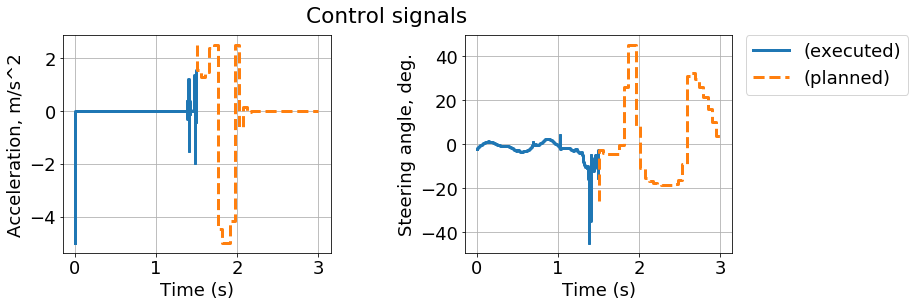

In [8]:
u_plt, u_ax1, u_ax2 = car.plot_u(u_plan, mpcprob.u_opt)
# control limits

## x-y plot of car's path
Arrows show velocity. Orange components are planned but not executed.

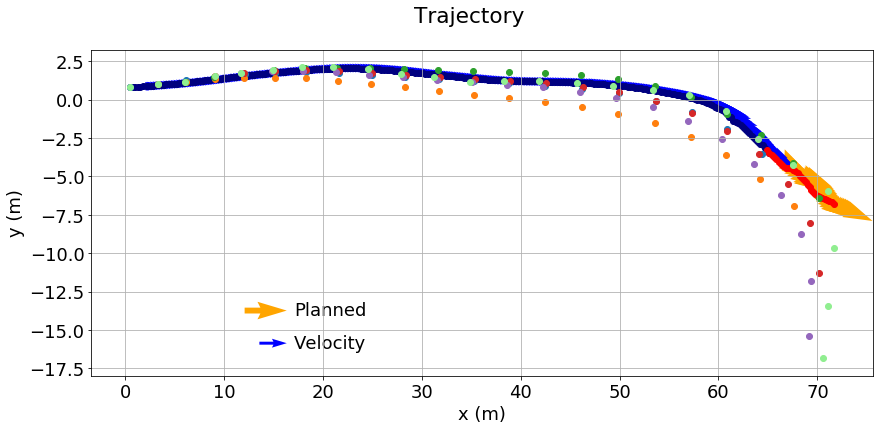

In [9]:
x_plt, x_ax = car.plot_x(x_plan, mpcprob.x_opt)
for i in range(0,5):
    roadrunner.segment_ptr = i
    x = np.linspace(0,1,20)
    xy = roadrunner.evaluate(x)
    #xy = roadrunner.to_world_frame(xy, roadrunner.angle[i], roadrunner.road_center[i,:])
    x_ax.scatter(xy[:,0], xy[:,1])
    
x_ax.scatter(test_road[0:25,0], test_road[0:25,1], color='lightgreen')

plt.show()

## x vs time and y vs time, separately, with the boundaries

Final state:
(x,y): 65.14942928718591 -3.447667139219838


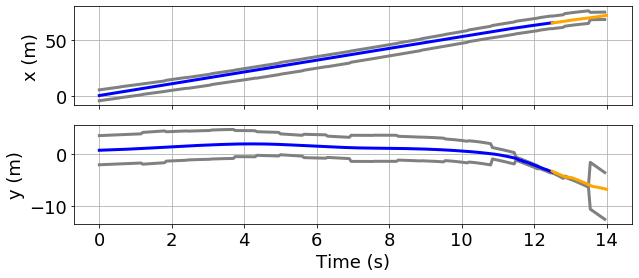

In [10]:
print("Final state:")
print("(x,y):", x_plan[0,-1], x_plan[1,-1])

fig1, ax1, ax2 = mpcprob.model.plot_with_time(x_plan, mpcprob.x_opt, boundary_up, boundary_low)

In [11]:
x_executed = x_plan
x_planned = mpcprob.x_opt

In [12]:
np.max([np.max(x_executed), np.max(x_planned)])

71.68981820822366